In [3]:
import numpy as np
from pySECS import SECS
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [17]:
import os
path='/usr/people/out/Documents/overview_map'
proj='-JM15C -P'
lims='-R-14/21/42/65'
psfile=f'{path}/map_overview.ps'
os.system(f'gmt pscoast {proj} {lims} -W0.25p -Ggrey -Slightblue -N1/0.25p -K> {psfile}' )
os.system(f'gmt psbasemap {proj} {lims} -Ba5 -BWeSn+t"Interpolation overview" -O -K>> {psfile}' )
os.system(f'gmt psxy {path}/current_area {proj} {lims} -Sc0.05cm -Gdarkgreen -O -K>> {psfile}')
os.system(f'gmt psxy {path}/station_coordinates {proj} {lims} -Sc0.2i -Gred -O -K>> {psfile}')
os.system(f'gmt pstext {path}/station_coordinatestext {proj} {lims} -F+f22pHelvetica,black -O -K>> {psfile}')
os.system(f'gmt psxy {path}/Dutch_area {proj} {lims} -W2p -Wblack -O -K>> {psfile}' )
os.system(f'gmt psxy {path}/legend {proj} {lims} -Sc0.2i -Gdarkgreen -O -K>> {psfile}')
os.system(f'gmt psxy {path}/legend2 {proj} {lims} -Sc0.2i -Gred -O -K>> {psfile}')
os.system(f'gmt psxy {path}/legend3 {proj} {lims} -Ss0.2i -Wblack -W2p -O -K>> {psfile}')
os.system(f'gmt pstext {path}/legendtext {proj} {lims} -F+f20pHelvetica,black -O -K>> {psfile}')
os.system(f'gmt pstext {path}/legendtext2 {proj} {lims} -F+f20pHelvetica,black -O -K>> {psfile}')
os.system(f'gmt pstext {path}/legendtext3 {proj} {lims} -F+f20pHelvetica,black -O>> {psfile}')
os.system(f'convert -density 300 {psfile} {path}/map_overview.png')

0

In [2]:
RE=6371e3
delta=0.5
lat_min, lat_max = 43, 63+delta # region where source currents are located
lon_min, lon_max = -13, 20+delta
lats = np.arange(lat_min, lat_max, delta)
lons = np.arange(lon_min, lon_max, delta)

nlat = len(lats)
nlon = len(lons)

xx, yy = np.meshgrid(lons, lats) #make nice mesh
newfile=pd.DataFrame(columns=['lon','lat'])
for i in range(nlon*nlat):
    newfile.loc[i]=xx.item(i), yy.item(i)
newfile.to_csv(path_or_buf='/usr/people/out/Documents/overview_map/current_area', sep=' ', index=False, header=False)

sec_loc=np.zeros((nlat*nlon,3))
for i in range(nlat*nlon): #add poles to sec_loc
    sec_loc[i,:]=[yy.item(i),xx.item(i),RE+110e3] #system is 110 km above ground with multiple poles

system_df = SECS(sec_df_loc=sec_loc) #initiate new divergence free system using poles (only df free, see paper)
obs_loc=np.array([[55.314,356.794,RE],[50.995,355.516,RE]]) #input observation location
value=np.array([[-187.13329221300592,223.11727024682722,272.42839777066547],[-234.2759175860483, 179.67608083890985, 28.206329473636288]]) #input observed values, Bx, By, Bz
len(value)
system_df.fit(obs_loc,value) #fit currents to values

In [19]:
print(system_df.sec_amps) #this is where the amplitudes are stored

[[ 3.51372269e+12  5.40976325e+12  7.25255768e+12  8.92024791e+12
   1.03126720e+13  1.13739071e+13  1.20973081e+13  1.25140232e+13
   1.26750058e+13  1.26358002e+13  1.24475488e+13  1.21532866e+13
   1.17873495e+13  1.13761908e+13  1.09396545e+13  1.04922745e+13
   3.14285767e+12  5.62821559e+12  8.07561115e+12  1.02593532e+13
   1.19971172e+13  1.32081106e+13  1.39159789e+13  1.42073515e+13
   1.41856543e+13  1.39438411e+13  1.35555184e+13  1.30755399e+13
   1.25435084e+13  1.19873842e+13  1.14264564e+13  1.08736462e+13
   2.29315245e+12  5.72081222e+12  9.20025417e+12  1.22484428e+13
   1.44766622e+13  1.57815187e+13  1.63107211e+13  1.62965443e+13
   1.59396002e+13  1.53802793e+13  1.47101817e+13  1.39884401e+13
   1.32532058e+13  1.25287219e+13  1.18297933e+13  1.11647978e+13
   2.93252310e+11  5.29760389e+12  1.07934300e+13  1.55224858e+13
   1.84105204e+13  1.94682562e+13  1.93756031e+13  1.87191516e+13
   1.78137253e+13  1.68090338e+13  1.57816236e+13  1.47748903e+13
   1.38139

In [28]:
pred_loc=np.array([[55.314,356.794,RE],[50.995,355.516,RE]]) #location to be predicted
prediction=system_df.predict(pred_loc)
print(prediction) #predict value at location using current scaling

[[-187.13329221  223.11727025  272.42839777]
 [-234.27591759  179.67608084   28.20632947]]


In [103]:
def mag_interpolate(loc,val,latlon,delta):
    import numpy as np
    from pySECS import SECS
    if loc.shape[-1] != 3:
        raise ValueError("Observation locations must have 3 columns (lat, lon, r)")
    if val.shape[-1] != 3:
        raise ValueError("Observed values must have 3 columns (Bx(theta), By(phi), Bz(r))")
    if latlon.shape[-1] != 3:
        raise ValueError("Observed values must have 1 row and 4 columns (latmin, latmax, lonmin, lonmax)")
    RE=6371e3
    
    latlon[1]+=delta
    latlon[3]+=delta
    
    lats = np.arange(latlon[0], latlon[1], delta)
    lons = np.arange(latlon[2], latlon[3], delta)

    nlat = len(lats)
    nlon = len(lons)

    xx, yy = np.meshgrid(lons, lats) #make nice mesh

    sec_loc=np.zeros((nlat*nlon,3))
    for i in range(nlat*nlon): #add poles to sec_loc
        sec_loc[i,:]=[yy.item(i),xx.item(i),RE+110e3] #system is 110 km above ground with multiple poles

    system_df = SECS(sec_df_loc=sec_loc) #initiate new divergence free system using poles (only df free, see paper)
    
    system_df.fit(loc,val) #fit currents to values
    
################## The prediction/interpolation begins ################
    predlats = np.arange(50.8, 53.5, 0.05) #Netherlands+Belgium&Germany
    predlons = np.arange(3.5, 8.15, 0.05)

    prednlat = len(predlats)
    prednlon = len(predlons)

    predxx, predyy = np.meshgrid(predlons, predlats) #make nice mesh

    pred_loc=np.zeros((prednlat*prednlon,3))
    for i in range(prednlat*prednlon): #add locations
        pred_loc[i,:]=[predyy.item(i),predxx.item(i),RE] #system is at ground
    
    prediction=system_df.predict(pred_loc)
    result=np.zeros((prednlat*prednlon,4))
    for i in range(prednlat*prednlon):
        result[i,:]=[predyy.item(i),predxx.item(i),prediction[i,0],prediction[i,1]]
    return result

<IPython.core.display.Javascript object>


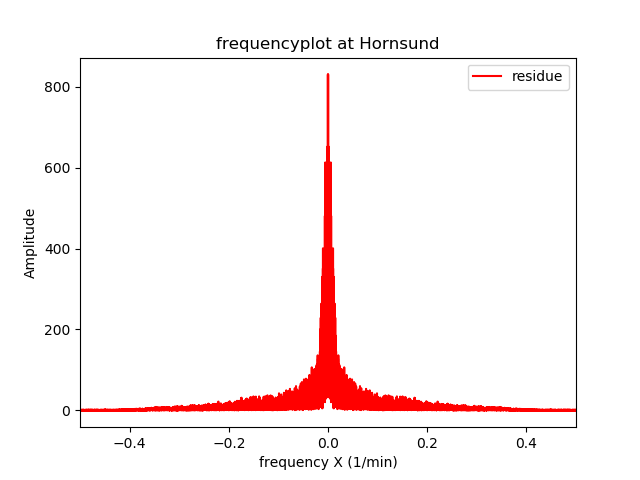

<IPython.core.display.Javascript object>


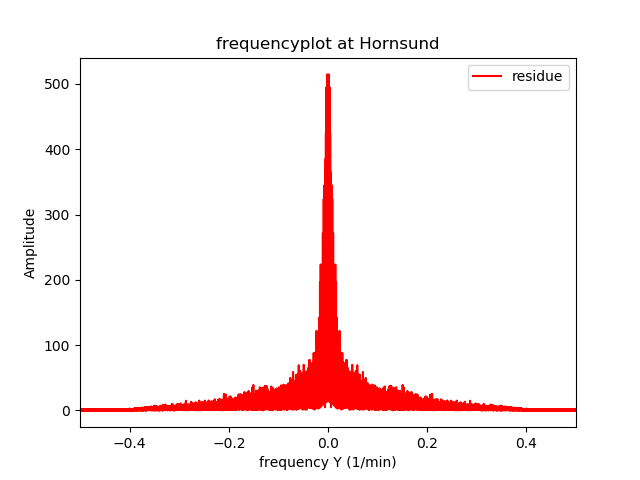

<IPython.core.display.Javascript object>


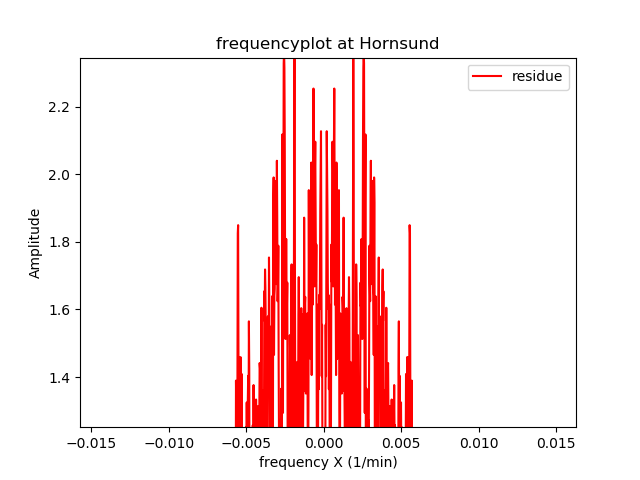

<IPython.core.display.Javascript object>


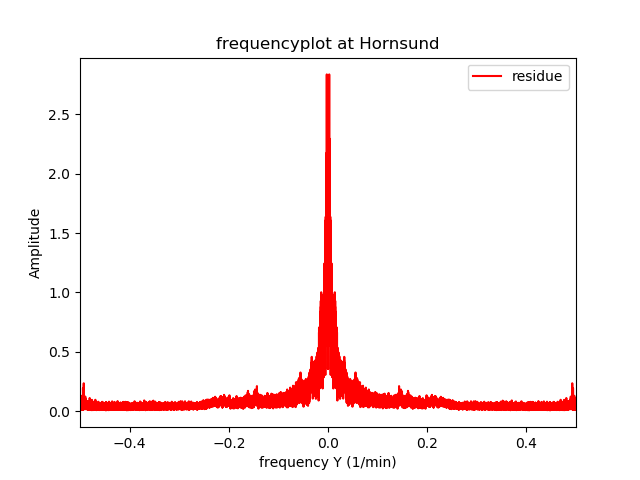

In [19]:
filename='magnetic_data/17-3-2015_sec/hrn20150317psec.sec'
datastart=26
types=True
minsec=False
# import basic packages and earth magnetic model
import scipy.signal.windows as spsw
import os
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import re
import chaosmagpy as cp
from chaosmagpy.model_utils import synth_values
from chaosmagpy.data_utils import mjd2000
from chaosmagpy.plot_utils import plot_timeseries
model = cp.load_CHAOS_matfile('CHAOS-6-x9.mat')
possible_characters = ('-', ' ')
path='/usr/people/out/Documents/Magnetic_field/'

##### calculate values from observation station #####
# read-in file of station
File=open(f'{path}{filename}','r') # open file
counter=0
HorX=[] # make some lists
DeclY=[]
VertZ=[]
X=[]
N=0
for line in File:
    if counter==2:
        words=line.split()
        station=words[2]
    if counter==4:
        words=line.split()
        lat=float(words[2]) # latitude station
    if counter==5:
        words=line.split()
        phi=float(words[2]) # longitude station
    if counter>=datastart-1: #read when the data starts
        N+=1
        if counter==datastart-1:
            dates=re.split("[%s]" % ("".join(possible_characters)), line) # get start date

        words=line.split()
        HorX.append(float(words[3])) # get horizontal or X-component
        DeclY.append(float(words[4])) # get 'declination' or Y-component
        VertZ.append(float(words[5])) # get vertical component or Z-component
    counter+=1
File.close()
# try:
#     os.mkdir(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}')
# except Exception:
#     pass

if types: #if given in XYZ, types==true
    X=np.multiply(-1,HorX)
    Y=DeclY
    Z=np.multiply(-1,VertZ)

else: #if given in HDZ, types==false
    for item in range(len(DeclY)):
        X.append(-np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
    Y=DeclY
    Z=np.multiply(-1,VertZ)
##### calculate model value of magnetic field #####
# set up
if minsec:
    secormin='sec'
else:
    secormin='min'

time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])), 
                           mjd2000(int(dates[0]),int(dates[1]),int(dates[2])+1), num=N)
radius = 6371.2
theta = 90.-lat #90 degrees minus latitude

# calculate values for temporal and static field
coeffs = model.synth_coeffs_tdep(time, nmax=16, deriv=0)
B_radius, B_theta, B_phi = synth_values(coeffs, radius, theta, phi)
coeffstat = model.synth_coeffs_static()
Bstat_radius, Bstat_theta, Bstat_phi = synth_values(coeffstat, radius, theta, phi)

##### subtract the two data sets! #####
SpaceX=X-B_theta-Bstat_theta
SpaceY=Y-B_phi-Bstat_phi
SpaceZ=Z-B_radius-Bstat_radius

##### plot data #####
# figx=plt.figure(figsize=(20,10))
# ax1=figx.add_subplot(311)
# ax11=figx.add_subplot(312)
# ax12=figx.add_subplot(313)
# ax1.set_title('$B_\\theta$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
# ax12.set_xlabel('time (days after 1 jan 2000)')
# ax11.set_ylabel('$B_\\theta$ (nt)')
# ax11.plot(time,X,label='observed',color='blue')
# ax12.plot(time,B_theta+Bstat_theta,label='model',color='green')
# ax1.plot(time,SpaceX,label='residue',color='red')
# ax1.legend()
# ax11.legend()
# ax12.legend()

# figy=plt.figure(figsize=(20,10))
# ax2=figy.add_subplot(311)
# ax21=figy.add_subplot(312)
# ax22=figy.add_subplot(313)
# ax2.set_title('$B_\\phi$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
# ax22.set_xlabel('time (days after 1 jan 2000)')
# ax21.set_ylabel('$B_\\phi$ (nt)')
# ax21.plot(time,Y,label='total',color='blue')
# ax22.plot(time,B_phi+Bstat_phi,label='model',color='green')
# ax2.plot(time,SpaceY,label='residue',color='red')
# ax2.legend()
# ax21.legend()
# ax22.legend()

# figz=plt.figure(figsize=(20,10))
# ax3=figz.add_subplot(311)
# ax31=figz.add_subplot(312)
# ax32=figz.add_subplot(313)
# ax3.set_title('$B_r$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
# ax32.set_xlabel('time (days after 1 jan 2000)')
# ax31.set_ylabel('$B_r$ (nt)')
# ax31.plot(time,Z,label='total',color='blue')
# ax32.plot(time,B_radius+Bstat_radius,label='model',color='green')
# ax3.plot(time,SpaceZ,label='residue',color='red')
# ax3.legend()
# ax31.legend()
# ax32.legend()
# plt.show()

# figall=plt.figure(figsize=(20,10))
# ax4=figall.add_subplot(311)
# ax41=figall.add_subplot(312)
# ax42=figall.add_subplot(313)
# ax4.set_title('Radial component')
# ax41.set_title('Longitudinal component')
# ax41.set_ylabel('nanoteslas')
# ax42.set_title('Latitudional component')
# ax4.plot(time,SpaceZ,color='red')
# ax41.plot(time,SpaceY,color='red')
# ax42.plot(time,SpaceX,color='red')
# plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/SWresult.png')

##### calculate frequency spectrum #####
# try to get time derivative and frequency at which this happens, only horizontal components matter
dXdt=np.zeros(len(SpaceX)) # define length array
dYdt=np.zeros(len(SpaceY))

for item in range(len(SpaceX)-1): # obtain derivative
    dXdt[item]=SpaceX[item+1]-SpaceX[item]
    dYdt[item]=SpaceY[item+1]-SpaceY[item]

# figx=plt.figure()
# ax1=figx.add_subplot()
# ax1.set_title('d$B_X$/dt at ' + station)
# ax1.set_xlabel('time (days after 1 jan 2000)')
# ax1.set_ylabel(f'd$B_X$/dt (nt/{secormin})')
# ax1.plot(time,dXdt,label='residue',color='red')
# ax1.legend()
# plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtX.png')

# figy=plt.figure()
# ax2=figy.add_subplot()
# ax2.set_title('d$B_Y$/dt at ' + station)
# ax2.set_xlabel('time (days after 1 jan 2000)')
# ax2.set_ylabel(f'd$B_Y$/dt (nt/{secormin})')
# ax2.plot(time,dYdt,label='residue',color='red')
# ax2.legend()
# #     plt.show()
# plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtY.png')

# get frequencyplot
dXdt2=dXdt[int(N/2):]*spsw.hann(int(N/2))
dYdt2=dYdt[int(N/2):]*spsw.hann(int(N/2))
FdXshift=np.fft.fft(dXdt2) # get frequency component
FdX=np.abs(np.fft.fftshift(FdXshift)) # shift it to the middle of the plot
FdYshift=np.fft.fft(dYdt2) # get frequency component
FdY=np.abs(np.fft.fftshift(FdYshift)) # shift it to the middle of the plot
meanx+=FdX/FdX.max()
meany+=FdY/FdY.max()

if minsec:
    Nu_c=1./(2.*1/60) # Nyquist frequency (1/min)
    df=60./int(N/2) #frequencystepping
else:
    Nu_c=1./(2*1.)
    df=1./int(N/2)
freq=np.arange(-Nu_c,Nu_c,df)
# freq=np.fft.fftfreq(len(dXdt),60)
figfx=plt.figure()
ax1=figfx.add_subplot()
ax1.set_title('frequencyplot at ' + station)
ax1.set_xlabel('frequency X (1/min)')
ax1.set_xlim(-0.5,0.5)
ax1.set_ylabel('Amplitude')
ax1.plot(freq,FdX,label='residue',color='red')
ax1.legend()
plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/frequencyX.png')
figfy=plt.figure()
ax2=figfy.add_subplot()
ax2.set_title('frequencyplot at ' + station)
ax2.set_xlabel('frequency Y (1/min)')
ax2.set_xlim(-0.5,0.5)
ax2.set_ylabel('Amplitude')
ax2.plot(freq,FdY,label='residue',color='red')
ax2.legend()
plt.show()

figfxm=plt.figure()
ax1=figfxm.add_subplot()
ax1.set_title('frequencyplot at ' + station)
ax1.set_xlabel('frequency X (1/min)')
ax1.set_xlim(-0.5,0.5)
ax1.set_ylabel('Amplitude')
ax1.plot(freq,meanx,label='residue',color='red')
ax1.legend()
plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/frequencyX.png')
figfym=plt.figure()
ax2=figfym.add_subplot()
ax2.set_title('frequencyplot at ' + station)
ax2.set_xlabel('frequency Y (1/min)')
ax2.set_xlim(-0.5,0.5)
ax2.set_ylabel('Amplitude')
ax2.plot(freq,meany,label='residue',color='red')
ax2.legend()
plt.show()
# plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/frequencyY.png')


# ##### save files #####
#     newfile=pd.DataFrame(columns=['B_theta (nt)','B_phi (nt)','B_r (nt)','dBx/dt','dBy/dt'])
#     for i in range(N):
#         newfile.loc[i]=SpaceX[i], SpaceY[i], SpaceZ[i], dXdt[i], dYdt[i]
#     newfile.to_csv(path_or_buf=f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/allresults.csv', sep=';', index=False, header=True)

In [14]:
meanx=0
meany=0

In [7]:
# test gevoeligheid delta
import os
import pandas as pd
import numpy as np
path = '/usr/people/out/Documents/Magnetic_field/gevoeligheid'

Delta1=pd.read_csv(f'{path}/delta1.csv.Y',sep=' ',header=None)
Deltagr05=pd.read_csv(f'{path}/Groter05.csv.Y',sep=' ',header=None)
Deltagrt05=pd.read_csv(f'{path}/Grootst05.csv.Y',sep=' ',header=None)
Deltagr=pd.read_csv(f'{path}/Groter.csv.Y',sep=' ',header=None)
Deltagrt=pd.read_csv(f'{path}/Grootst.csv.Y',sep=' ',header=None)

diff=np.zeros(len(Delta1))
for i in range(len(Delta1)):
    diff[i]=(abs(Deltagr.loc[i,2]-Deltagr05.loc[i,2]))
print(diff.sum()/len(Delta1))
print(diff.max())

0.7823381951174396
3.0807170003996163


In [2]:
import os
path='/usr/people/out/Documents/Magnetic_field/station_results/new_29-10-2003'
os.system(f'ffmpeg -framerate 20 -pattern_type glob -i "{path}/electric_field_east/electric_????.png" {path}/Electric_east.mp4')

0

In [1]:
import os
path='/usr/people/out/Documents/Magnetic_field/station_results'
os.system(f'ffmpeg -f concat -safe 0 -i {path}/video_location.txt -c copy {path}/HalloweenGIC.mp4')

0

In [3]:
import os
path='/nobackup/users/out/Magnetic_field'
for number in range(1440):
    if number < 10:
        number2=f'000{number}'
    if number > 9 and number < 100:
        number2=f'00{number}'
    if number > 99 and number < 1000:
        number2=f'0{number}'
    if number > 999:
        number2=f'{number}'
    os.system(f'cp {path}/31-10-2003/interpolation/minute_{number2}.csv {path}/Halloween/interpolation/minute_{number+1440*2}.csv')
    os.system(f'cp {path}/31-10-2003/interpolation/minute_{number2}.csv.Y {path}/Halloween/interpolation/minute_{number+1440*2}.csv.Y')

In [4]:
# Create transferfunction!
def transferfunction(freq,model): #Where B is given, NOT H!
    mu=4*np.pi*10**(-7)
    if freq<=0:
        raise Exception('Frequency cannot be any lower or equal to zero!')
    if freq<=10**-9:
        Zn=0
    else:
        # conductivity parameters
        if model == 1:
            cond=np.zeros((2,4)) #business as usual
            cond[0,:]=[1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
        elif model == 2:
            cond=np.zeros((2,5)) #deep ocean
            cond[0,:]=[4.,1,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[4000,2000,6000,4000,0] #depth top to bottom in m
        elif model == 3:
            cond=np.zeros((2,2)) #GIC in Europe paper
            cond[0,:]=[1./38.5,1./0.385] #conductivity top to bottom
            cond[1,:]=[150000,0] #depth top to bottom in m
        elif model == 4:
            cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C-RESPONSES: oceanic mantle
            cond[0,:]=[1./10**3,1./20.,1./2.,1./0.42] #conductivity top to bottom
            cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
        elif model == 5:
            cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C0-RESPONSES: continental mantle
            cond[0,:]=[1./(3*10**3),1./70.,1./16.,1./0.42] #conductivity top to bottom
            cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
        elif model == 6: #Pirjola et al 2014: Geomagnetically induced currents in Europe 
            cond=np.zeros((2,5))
            cond[0,:]=[1./(40),1./3.,1./2000.,1./118., 1/15.] #conductivity top to bottom
            cond[1,:]=[400,1300,140000,170000,0] #depth top to bottom in m
        else:
            cond=np.zeros((2,5)) #bit of water (50m)
            cond[0,:]=[4,1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[50,2000,6000,4000,0] #depth top to bottom in m
            
        #first do bottom layer
        kn=np.sqrt(1j*freq*mu*cond[0,-1])
        Zn=1j*freq*mu/kn

        # iterate from bottom to top
        for item in range(2,len(cond[0])+1): #we go in opposite direction later, see Trichtchenko and Boteler (2002)
            kn=np.sqrt(1j*freq*mu*cond[0,-item])
            rn=(1-kn*(Zn/(1j*freq*mu)))/(1+kn*(Zn/(1j*freq*mu)))
            Zn=1j*freq*mu*((1-rn*np.exp(-2*kn*cond[1,-item]))/(kn*(1+rn*np.exp(-2*kn*cond[1,-item]))))

    return Zn/mu

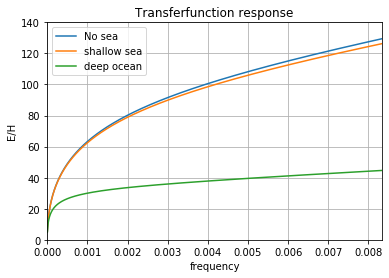

In [8]:
# import numpy as np
import matplotlib.pyplot as plt
mu=4*np.pi*10**(-7)

freqvector=np.arange(1/(60*60*24*3),1/(2*60)+1/(60*60*24*3),1/(60*60*24*3))
Zn1=np.zeros(len(freqvector),dtype='complex')
Zn0=np.zeros(len(freqvector),dtype='complex')
Zn2=np.zeros(len(freqvector),dtype='complex')
Zn3=np.zeros(len(freqvector),dtype='complex')
Zn4=np.zeros(len(freqvector),dtype='complex')
Zn5=np.zeros(len(freqvector),dtype='complex')
Zn6=np.zeros(len(freqvector),dtype='complex')
for item in range(len(freqvector)):
    Zn1[item]=(transferfunction(freqvector[item],1))
    Zn0[item]=(transferfunction(freqvector[item],0))
    Zn2[item]=(transferfunction(freqvector[item],2))
    Zn3[item]=(transferfunction(freqvector[item],3))
    Zn4[item]=(transferfunction(freqvector[item],4))
    Zn5[item]=(transferfunction(freqvector[item],5))
    Zn6[item]=(transferfunction(freqvector[item],6))
#     Zn2[item]=(Zn0[item]/(np.cosh(50*np.sqrt(1j*freqvector[item]*mu*4))+np.sqrt(1j*freqvector[item]*mu/4.)/Zn0[item]*np.sinh(50*np.sqrt(1j*freqvector[item]*mu*4))))
#     print((np.cosh(50*np.sqrt(1j*freqvector[item]*mu*4))+np.sqrt(1j*freqvector[item]*mu/4.)/Zn0[item]*np.sinh(50*np.sqrt(1j*freqvector[item]*mu*4))))
fig=plt.figure()
ax=fig.add_subplot()
ax.set_title('Transferfunction response')
ax.set_xlabel("frequency")
ax.set_ylabel("E/H")
ax.plot(freqvector,abs(Zn1),label='No sea')
ax.plot(freqvector,abs(Zn0),label='shallow sea')
ax.plot(freqvector,abs(Zn2),label='deep ocean')
# ax.plot(freqvector,abs(Zn3),label='EurisGic sea model')
# ax.plot(freqvector,abs(Zn4),label='Paper: oceanic mantle')
# ax.plot(freqvector,abs(Zn5),label='Paper: continental mantle')
# ax.plot(freqvector,abs(Zn6),label='Pirjola 2014: mean Europe')
ax.legend()
ax.set_xlim(0,1/(2*60)+1/(60*60*24*3))
ax.set_ylim(0,140)
ax.grid()
# plt.plot()
plt.savefig(f'/usr/people/out/Documents/Magnetic_field/station_results/transferfunction.png',bbox_inches='tight')

In [2]:
# Create transferfunction!
def faultytransferfunction(freq,model): #Where B is given, NOT H!
    mu=4*np.pi*10**(-7)
    if freq<=0:
        raise Exception('Frequency cannot be any lower or equal to zero!')
    if freq<=10**-5:
        Zn=0
    else:
        # conductivity parameters
        if model == 1:
            cond=np.zeros((2,4)) #business as usual
            cond[0,:]=[1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
        elif model == 2:
            cond=np.zeros((2,4)) #deep ocean
            cond[0,:]=[4.,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
        elif model == 3:
            cond=np.zeros((2,2)) #GIC in Europe paper
            cond[0,:]=[1./38.5,1./0.385] #conductivity top to bottom
            cond[1,:]=[150000,0] #depth top to bottom in m
        elif model == 4:
            cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C-RESPONSES: oceanic mantle
            cond[0,:]=[1./10**3,1./20.,1./2.,1./0.42] #conductivity top to bottom
            cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
        elif model == 5:
            cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C0-RESPONSES: continental mantle
            cond[0,:]=[1./(3*10**3),1./70.,1./16.,1./0.42] #conductivity top to bottom
            cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
        else:
            cond=np.zeros((2,5)) #bit of water (50m)
            cond[0,:]=[4,1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[100,2000,6000,4000,0] #depth top to bottom in m
            
        #first do bottom layer
        kn=np.sqrt(1j*freq*mu*cond[0,-1])
        Zn=1j*freq/kn

        # iterate from bottom to top
        for item in range(2,len(cond[0])+1): #we go in opposite direction later, see Trichtchenko and Boteler (2002)
            kn=np.sqrt(1j*freq*mu*cond[0,-item])
            rn=(1-kn*(Zn/(1j*freq*mu)))/(1+kn*(Zn/(1j*freq*mu)))
            Zn=1j*freq*((1-rn*np.exp(-2*kn*cond[1,-item]))/(kn*(1+rn*np.exp(-2*kn*cond[1,-item]))))

    return Zn

[]

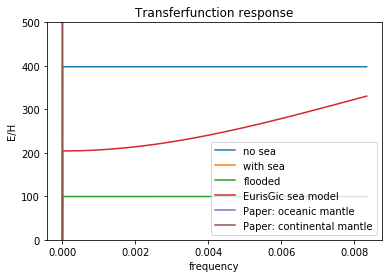

In [63]:
import numpy as np
import matplotlib.pyplot as plt

freqvector=np.arange(1/(60*60*24*3),1/(2*60)+1/(60*60*24*3),1/(60*60*24*3))
Zn1=np.zeros(len(freqvector),dtype='complex')
Zn0=np.zeros(len(freqvector),dtype='complex')
Zn2=np.zeros(len(freqvector),dtype='complex')
Zn3=np.zeros(len(freqvector),dtype='complex')
Zn4=np.zeros(len(freqvector),dtype='complex')
Zn5=np.zeros(len(freqvector),dtype='complex')
for item in range(len(freqvector)):
    Zn1[item]=(faultytransferfunction(freqvector[item],1))
    Zn0[item]=(faultytransferfunction(freqvector[item],0))
    Zn2[item]=(faultytransferfunction(freqvector[item],2))
    Zn3[item]=(faultytransferfunction(freqvector[item],3))
    Zn4[item]=(faultytransferfunction(freqvector[item],4))
    Zn5[item]=(faultytransferfunction(freqvector[item],5))
    
fig=plt.figure()
ax=fig.add_subplot()
ax.set_title('Transferfunction response')
ax.set_xlabel("frequency")
ax.set_ylabel("E/H")
ax.set_ylim(0,500)
ax.plot(freqvector,Zn1,label='no sea')
ax.plot(freqvector,Zn0,label='with sea')
ax.plot(freqvector,Zn2,label='flooded')
ax.plot(freqvector,Zn3,label='EurisGic sea model')
ax.plot(freqvector,Zn4,label='Paper: oceanic mantle')
ax.plot(freqvector,Zn5,label='Paper: continental mantle')
ax.legend()
plt.plot()

In [7]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
path='/nobackup/users/out/Magnetic_field/Halloween'

#reading in all GIC files
# os.system(f"ls {path}/GIC/GIC_????.csv > {path}/tempx.txt")
os.system(f"ls {path}/electric_field_north/electric_????.csv > {path}/tempx.txt")
os.system(f"ls {path}/electric_field_east/electric_????.csv > {path}/tempy.txt")
f=open(f"{path}/tempx.txt")
g=open(f"{path}/tempy.txt")
stringx=[]
stringy=[]

A=np.arange(3,21)
B=np.arange(46,54,1)
stationlist=np.hstack([0,1,A,28,29,32,33,35,43,44,B])

GIC_datax=np.zeros((1440*3,14964))
GIC_datay=np.zeros((1440*3,14964))
GIC_data=np.zeros((1440*3,14964))
GIC_data7=np.zeros((1440*3,len(stationlist)))

for item in f:
    item=item.rstrip('\n')
    stringx.append(item)
for item in g:
    item=item.rstrip('\n')
    stringy.append(item)
stringx=sorted(stringx)
stringy=sorted(stringy)
for counter,time in enumerate(stringx):
    GIC_filex=pd.read_csv(time, delimiter=' ')
    GICx=GIC_filex.to_numpy()
#     GIC_data[counter,:]=GICx[:,2]
    GIC_datax[counter,:]=GICx[:,2]
for counter,time in enumerate(stringy):
    GIC_filey=pd.read_csv(time, delimiter=' ')
    GICy=GIC_filey.to_numpy()
    GIC_datay[counter,:]=GICy[:,2]

GIC_data=np.sqrt(GIC_datax**2+GIC_datay**2)
os.system(f'rm {path}/tempx.txt')
os.system(f'rm {path}/tempy.txt')

for counter,item in enumerate(stationlist):
    GIC_data7[:,counter]=GIC_data[:,item]

predlats = np.arange(49, 54.04, 0.05) #Netherlands+Belgium&Germany
predlons = np.arange(3.3, 9.64, 0.05)
predlatseng = np.arange(51.4, 52.04, 0.05) #seacable england
predlonseng = np.arange(0.7, 3.29, 0.05)
predlatsnor = np.arange(54.05, 58.34, 0.05) #seacable norway
predlonsnor = np.arange(6.1, 6.94, 0.05)
predxx1, predyy1 = np.meshgrid(predlons, predlats) #make nice mesh
predxx2, predyy2 = np.meshgrid(predlonseng, predlatseng)
predxx3, predyy3 = np.meshgrid(predlonsnor, predlatsnor)
predxx=np.concatenate((predxx1.flatten(),predxx2.flatten(),predxx3.flatten()))
predyy=np.concatenate((predyy1.flatten(),predyy2.flatten(),predyy3.flatten()))

nrpoint=len(predlats)*len(predlons)+len(predlatseng)*len(predlonseng)+len(predlatsnor)*len(predlonsnor)

In [62]:
# import matplotlib
# from time import sleep
# matplotlib.use('nbagg')
# plt.rcParams.update({'font.size': 14}) 
# timevector=np.linspace(0,24*3,1440*3)
# fig1=plt.figure(figsize=(20,15))
# ax1=fig1.add_subplot()
# levels = np.arange(0, 1, 10**-8)
# for item in range(0,1440*3,60):
# ax1=plt.contour(np.reshape(predxx1,(101,127)),np.reshape(predyy1,(101,127)),np.reshape(GIC_data[0,0:12827],(101,127)), colors='black')
# ax1.cmap.set_over('red')
# ax1.cmap.set_under('blue')
# ax1=plt.
# plt.plot()    
# plt.subplots_adjust(left=0)
# lgd=ax1.legend(bbox_to_anchor=(1.01,1))
#     ax1.clear()
#     ax1.set_title(f'electric field during Halloween after {item/60} hours')
#     ax1.set_ylabel('Latitude (degrees)')
#     ax1.set_xlabel('Longitude (degrees)')
#     im=ax1.contour(np.reshape(predxx1,(101,127)),np.reshape(predyy1,(101,127)),np.reshape(GIC_data[item,0:12827],(101,127)), 3, colors='black')
#     plt.clabel(im, levels, inline=True, fontsize=8)

#     plt.imshow(np.reshape(GIC_data[0,0:12827],(101,127)), extent=[3.3, 9.6, 49, 54], origin='lower',
#                cmap='RdGy', alpha=0.5)
#     if item==0:
#         plt.colorbar()
    
#     plt.gcf().canvas.draw()
#     sleep(1)
#     plt.colorbar();
#     sleep(0.1)
predlats = np.arange(49, 54.04, 0.05) #Netherlands+Belgium&Germany
predlons = np.arange(3.3, 9.64, 0.05)
predxx1, predyy1 = np.meshgrid(predlons, predlats) #make nice mesh
predxx1=predxx1.flatten()
predyy1=predyy1.flatten()
newfile=pd.DataFrame(columns=['lon','lat','value'])
for item in range(0,1440*3,1):
    newfile.at[:,'value']=GIC_data[item,:12827]
    newfile.at[:,'lon']=predxx1
    newfile.at[:,'lat']=predyy1
    if item<10:
        newfile.to_csv(path_or_buf=f'/nobackup/users/out/Magnetic_field/Halloween/electric_field/electric_000{item}.csv', sep=' ', index=False, header=False)
    if item<100 and item>9:
        newfile.to_csv(path_or_buf=f'/nobackup/users/out/Magnetic_field/Halloween/electric_field/electric_00{item}.csv', sep=' ', index=False, header=False)
    if item<1000 and item>99:
        newfile.to_csv(path_or_buf=f'/nobackup/users/out/Magnetic_field/Halloween/electric_field/electric_0{item}.csv', sep=' ', index=False, header=False)
    if item>999:
        newfile.to_csv(path_or_buf=f'/nobackup/users/out/Magnetic_field/Halloween/electric_field/electric_{item}.csv', sep=' ', index=False, header=False)
#     newfile.to_csv(path_or_buf=f'/nobackup/users/out/Magnetic_field/Halloween/electric_field/Hminute_000{item}.csv', sep=' ', index=False, header=False)

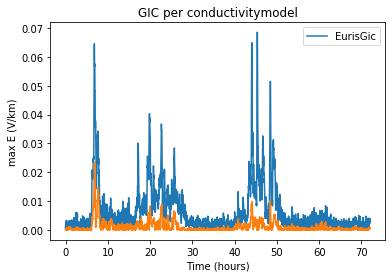

In [9]:
# maxE5=np.zeros(1440*3)
# minE5=np.zeros(1440*3)
# maxE6=np.zeros(1440*3)
# minE6=np.zeros(1440*3)
# maxE7=np.zeros(1440*3)
# minE7=np.zeros(1440*3)
# maxE0=np.zeros(1440*3)
# minE0=np.zeros(1440*3)
maxE1=np.zeros(1440*3)
minE1=np.zeros(1440*3)
for item in range(1440*3):
#     maxE5[item]=max(GIC_data5[item,:])
#     minE5[item]=min(GIC_data5[item,:])
#     maxE6[item]=max(GIC_data6[item,:])
#     minE6[item]=min(GIC_data6[item,:])
#     maxE7[item]=max(GIC_data7[item,:])
#     minE7[item]=min(GIC_data7[item,:])
#     maxE0[item]=max(GIC_data0[item,:])
#     minE0[item]=min(GIC_data0[item,:])
    maxE1[item]=max(GIC_data[item,:])
    minE1[item]=min(GIC_data[item,:])
# (max(GIC_data[45*60+29,:]))
fig=plt.figure()
ax=fig.add_subplot()
timevector=np.linspace(0,24*3,1440*3)
ax.set_title('GIC per conductivitymodel')
ax.set_ylabel('max E (V/km)')
ax.set_xlabel('Time (hours)')
# ax.plot(timevector,maxE6,label='Mean europe')
# ax.plot(timevector,minE6*1000)
# ax.plot(timevector,maxE5,label='Continental mantle')
# ax.plot(timevector,minE5*1000)
# ax.plot(timevector,maxE7,label='Combi')
# ax.plot(timevector,minE7*1000)
# ax.plot(timevector,maxE0,label='Seawater')
# ax.plot(timevector,minE0*1000)
ax.plot(timevector,maxE1*1000,label='EurisGic')
ax.plot(timevector,minE1*1000)
ax.legend()
plt.savefig('/nobackup/users/out/Magnetic_field/Halloween/Elec_models.png')


<IPython.core.display.Javascript object>


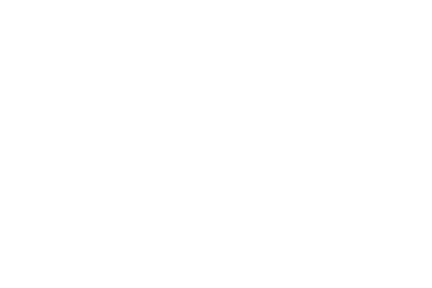

[]

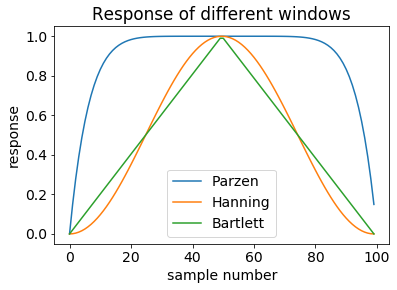

In [76]:
# testing windows
import numpy as np
from scipy.signal.windows import hann
from scipy.signal.windows import bartlett
import matplotlib.pyplot as plt

def Parzen(N):
    W=np.zeros(N)
    for nr in range(N):
        W[nr]=1-(2*(nr-N/2)/N)**8
    return W

arange=np.arange(0,100,1)
fig=plt.figure()
ax=fig.add_subplot()
ax.set_xlabel("sample number")
ax.set_ylabel("response")
ax.set_title("Response of different windows")
ax.plot(arange,Parzen(100),label='Parzen')
ax.plot(arange,hann(100),label='Hanning')
ax.plot(arange,bartlett(100),label='Bartlett')
ax.legend()
plt.plot()

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

#reading in all GIC files
os.system(f"ls /nobackup/users/out/Magnetic_field/Tozzi/*_2003-10-29/allresults.csv > /nobackup/users/out/Magnetic_field/Halloween/tempx.txt")
os.system(f"ls /nobackup/users/out/Magnetic_field/Tozzi/*_2003-10-30/allresults.csv > /nobackup/users/out/Magnetic_field/Halloween/tempy.txt")
os.system(f"ls /nobackup/users/out/Magnetic_field/Tozzi/*_2003-10-31/allresults.csv > /nobackup/users/out/Magnetic_field/Halloween/tempz.txt")
f=open(f"/nobackup/users/out/Magnetic_field/Halloween/tempx.txt")
g=open(f"/nobackup/users/out/Magnetic_field/Halloween/tempy.txt")
h=open(f"/nobackup/users/out/Magnetic_field/Halloween/tempz.txt")

stringx=[]
stringy=[]
stringz=[]

for item in f:
    item=item.rstrip('\n')
    stringx.append(item)
for item in g:
    item=item.rstrip('\n')
    stringy.append(item)
for item in h:
    item=item.rstrip('\n')
    stringz.append(item)

stringx=sorted(stringx)
stringy=sorted(stringy)
stringz=sorted(stringz)
print(stringx)
stationextreme=[2000,923,5077,769,769,923,1846,6308,462,615,1231,1154,615,308,1538,3231,769,2000,1308,615,615,3231,615,2462]
stationmax=np.zeros((len(stringx),3))

for counter,station in enumerate(stringx):
    GIC_filex=pd.read_csv(station, delimiter=';')
    GICx=GIC_filex.to_numpy()
    stationmax[counter,0]=max(GICx[:,6])
for counter,station in enumerate(stringy):
    GIC_filex=pd.read_csv(station, delimiter=';')
    GICx=GIC_filex.to_numpy()
    stationmax[counter,1]=max(GICx[:,6])
for counter,station in enumerate(stringz):
    GIC_filex=pd.read_csv(station, delimiter=';')
    GICx=GIC_filex.to_numpy()
    stationmax[counter,2]=max(GICx[:,6])
    print(station, max(stationmax[counter,:]),stationextreme[counter],stationextreme[counter]/max(stationmax[counter,:]))
    
os.system('rm /nobackup/users/out/Magnetic_field/Halloween/tempx.txt')
os.system('rm /nobackup/users/out/Magnetic_field/Halloween/tempy.txt')
os.system('rm /nobackup/users/out/Magnetic_field/Halloween/tempz.txt')

['/nobackup/users/out/Magnetic_field/Tozzi/Abisko_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Belsk_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Brorfelde_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Budkov_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Chambon_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Dourbes_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Ebro_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Eskdalemuir_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Furstenfeldbruck_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Hartland_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Hel_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Hornsund_2003-10-29/allresults.csv', '/nobackup/users/out/Magnetic_field/Tozzi/Hurbanovo_2003-

0

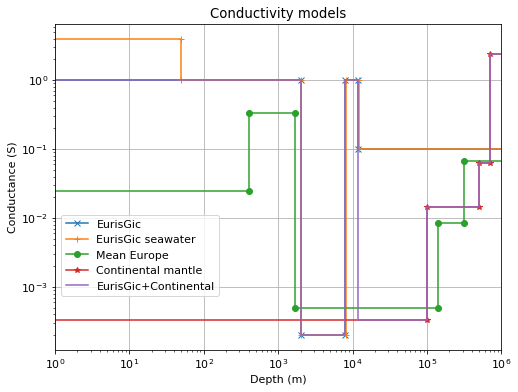

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def condu(model):
    if model == 1:
        cond=np.zeros((2,4)) #business as usual
        cond[0,:]=[1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
        cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
    elif model == 2:
        cond=np.zeros((2,4)) #deep ocean
        cond[0,:]=[4.,1./5000.,1./1.,1./10.] #conductivity top to bottom
        cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
    elif model == 3:
        cond=np.zeros((2,2)) #GIC in Europe paper
        cond[0,:]=[1./38.5,1./0.385] #conductivity top to bottom
        cond[1,:]=[150000,0] #depth top to bottom in m
    elif model == 4:
        cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C-RESPONSES: oceanic mantle
        cond[0,:]=[1./10**3,1./20.,1./2.,1./0.42] #conductivity top to bottom
        cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
    elif model == 5:
        cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C0-RESPONSES: continental mantle
        cond[0,:]=[1./(3*10**3),1./70.,1./16.,1./0.42] #conductivity top to bottom
        cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
    elif model == 6: #Pirjola et al 2014: Geomagnetically induced currents in Europe 
        cond=np.zeros((2,5))
        cond[0,:]=[1./(40),1./3.,1./2000.,1./118., 1/15.] #conductivity top to bottom
        cond[1,:]=[400,1300,140000,170000,0] #depth top to bottom in m
    else:
        cond=np.zeros((2,5)) #bit of water (50m)
        cond[0,:]=[4,1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
        cond[1,:]=[50,2000,6000,4000,0] #depth top to bottom in m
    return cond
condu1y=[0,2000,2000,8000,8000,12000,12000,1500000]
condu1x=[1./1.,1,1./5000.,1./5000.,1./1.,1./1.,1./10.,1./10.]
condu2x=[4,4,1./1.,1,1./5000.,1./5000,1./1.,1,1./10.,1./10.]
condu2y=[0,50,50,2050,2050,8050,8050,12050,12050,1500000]
condu3x=[1./(40),1/40.,1./3.,1/3.,1./2000.,1/2000.,1./118.,1/118.,1/15.,1/15.]
condu3y=[0,400,400,1700,1700,141700,141700,311700,311700,1500000]
condu4x=[1./(3*10**3),1./(3*10**3),1./70.,1./70.,1./16.,1./16.,1./0.42,1./0.42]
condu4y=[0,100000,100000,500000,500000,700000,700000,1500000]
condu5x=[1./1.,1,1./5000.,1./5000.,1./1.,1./1.,1./(3*10**3),1./(3*10**3),1./70.,1./70.,1./16.,1./16.,1./0.42,1./0.42]
condu5y=[0,2000,2000,8000,8000,12000,12000,100000,100000,500000,500000,700000,700000,1500000]

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot()
plt.rcParams.update({'font.size': 11}) 
ax.set_title('Conductivity models')
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Conductance (S)')
ax.plot(condu1y,condu1x,label='EurisGic', marker='x')
ax.plot(condu2y,condu2x,label='EurisGic seawater', marker='+')
ax.plot(condu3y,condu3x,label='Mean Europe', marker='o')
ax.plot(condu4y,condu4x,label='Continental mantle',marker='*')
ax.plot(condu5y,condu5x,label='EurisGic+Continental')
ax.legend(bbox_to_anchor=(0.38, 0.15))
ax.grid()
ax.set_xlim(1,10**6)
plt.yscale('log')
plt.xscale('log')
plt.savefig('/nobackup/users/out/Magnetic_field/Halloween/conductivity_models.png')

In [1]:
def Parzen(N):
    import numpy as np
    W=np.zeros(N)
    for nr in range(N):
        W[nr]=1-(2*(nr-N/2)/N)**8
    return W

In [5]:
def transferfunction(freq,model=1): #Where B is given, NOT H!
    import numpy as np
    mu=4*np.pi*10**(-7)
    if freq<=0:
        raise Exception('Frequency cannot be any lower or equal to zero!')
    elif freq<10**-5:
        Zn=0
    else:
        if model == 1:
            cond=np.zeros((2,4)) #business as usual
            cond[0,:]=[1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
        elif model == 2:
            cond=np.zeros((2,4)) #deep ocean
            cond[0,:]=[4.,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
        elif model == 3:
            cond=np.zeros((2,2)) #GIC in Europe paper
            cond[0,:]=[1./38.5,1./0.385] #conductivity top to bottom
            cond[1,:]=[150000,0] #depth top to bottom in m
        elif model == 4:
            cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C-RESPONSES: oceanic mantle
            cond[0,:]=[1./10**3,1./20.,1./2.,1./0.42] #conductivity top to bottom
            cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
        elif model == 5:
            cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C0-RESPONSES: continental mantle
            cond[0,:]=[1./(3*10**3),1./70.,1./16.,1./0.42] #conductivity top to bottom
            cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
        elif model == 6: #Pirjola et al 2014: Geomagnetically induced currents in Europe 
            cond=np.zeros((2,5))
            cond[0,:]=[1./(40),1./3.,1./2000.,1./118., 1/15.] #conductivity top to bottom
            cond[1,:]=[400,1300,140000,170000,0] #depth top to bottom in m
        elif model == 7: # combi model 
            cond=np.zeros((2,7))
            cond[0,:]=[1.,1./5000.,1.,1./(3*10**3),1/70.,1/16.,1/0.42] #conductivity top to bottom
            cond[1,:]=[2000,6000,4000,88000,400000,200000,0] #depth top to bottom in m
        else:
            cond=np.zeros((2,5)) #bit of water (50m)
            cond[0,:]=[4,1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[50,2000,6000,4000,0] #depth top to bottom in m

        #first do bottom layer
        kn=np.sqrt(1j*freq*mu*cond[0,-1])
        Zn=1j*freq*mu/kn

        # iterate from bottom to top
        for item in range(2,len(cond[0])+1): #we go in opposite direction later, see Trichtchenko and Boteler (2002)
            kn=np.sqrt(1j*freq*mu*cond[0,-item])
            rn=(1-kn*(Zn/(1j*freq*mu)))/(1+kn*(Zn/(1j*freq*mu)))
            Zn=1j*freq*mu*((1-rn*np.exp(-2*kn*cond[1,-item]))/(kn*(1+rn*np.exp(-2*kn*cond[1,-item]))))

    return Zn/mu

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
#         from time import process_time

# import magnetic field data in X/Y-direction (north)
magnetic_Xfiles=[]
magnetic_Yfiles=[]

############################# get the strings ###################################
os.system(f"ls /nobackup/users/out/Magnetic_field/Halloween/interpolation/minute_????.csv > /nobackup/users/out/Magnetic_field/Halloween/tempX.txt")
os.system(f"ls /nobackup/users/out/Magnetic_field/Halloween/interpolation/minute_????.csv.Y > /nobackup/users/out/Magnetic_field/Halloween/tempY.txt")
f=open(f'/nobackup/users/out/Magnetic_field/Halloween/tempX.txt')
for item in f:
    item=item.strip('\n')
    magnetic_Xfiles.append(item)
f.close()
os.system(f'rm /nobackup/users/out/Magnetic_field/Halloween/tempX.txt')
f=open(f'/nobackup/users/out/Magnetic_field/Halloween/tempY.txt')
for item in f:
    item=item.strip('\n')
    magnetic_Yfiles.append(item)
f.close()
os.system(f'rm /nobackup/users/out/Magnetic_field/Halloween/tempY.txt')

magnetic_Xfiles=sorted(magnetic_Xfiles) #sort to number 0000-1440
magnetic_Yfiles=sorted(magnetic_Yfiles)

for file in magnetic_Xfiles:
    Xfile=pd.read_csv(file, delimiter=' ', header=None)
    break
for file in magnetic_Yfiles:
    Yfile=pd.read_csv(file, delimiter=' ', header=None)
    break

lat=np.zeros(len(Xfile))
lon=np.zeros(len(Xfile))
MX_matrix=np.zeros((len(magnetic_Xfiles),len(Xfile)))#matrix for storing values (vertical same place, horizontal same time)
MX_parz=np.zeros((3*len(magnetic_Xfiles),len(Xfile)))
#         MXft_matrix=np.zeros((int(len(magnetic_Xfiles)/2)+1,len(Xfile)),dtype='complex')
MXft_matrix=np.zeros((3*int(len(magnetic_Xfiles)/2)+1,len(Xfile)),dtype='complex')
EX_matrix=np.zeros((len(magnetic_Yfiles),len(Yfile)))
EX_parz=np.zeros((3*len(magnetic_Yfiles),len(Yfile)))
EXft_matrix=np.zeros((3*int(len(magnetic_Yfiles)/2)+1,len(Yfile)),dtype='complex')
MY_matrix=np.zeros((len(magnetic_Yfiles),len(Yfile))) #matrix for storing values (vertical same place, horizontal same time)
MY_parz=np.zeros((3*len(magnetic_Yfiles),len(Yfile)))
#         MYft_matrix=np.zeros((int(len(magnetic_Yfiles)/2)+1,len(Yfile)),dtype='complex')
MYft_matrix=np.zeros((3*int(len(magnetic_Yfiles)/2)+1,len(Yfile)),dtype='complex')
EY_matrix=np.zeros((len(magnetic_Xfiles),len(Xfile)))
EY_parz=np.zeros((3*len(magnetic_Xfiles),len(Xfile)))
EYft_matrix=np.zeros((3*int(len(magnetic_Xfiles)/2)+1,len(Xfile)),dtype='complex')
newMXft_matrix=np.zeros((3*int(len(magnetic_Xfiles)/2)+1,len(Xfile)),dtype='complex')
newMYft_matrix=np.zeros((3*int(len(magnetic_Yfiles)/2)+1,len(Yfile)),dtype='complex')
# ################################################################################# 
# ########################### get the values ######################################
# ######################### first x-direction #####################################
print('setting up matrices!')
# t1_start=process_time()
for counter,file in enumerate(magnetic_Xfiles):
    Xfile=pd.read_csv(file, delimiter=' ', header=None)
    values=Xfile.to_numpy()
    MX_matrix[counter,:]=values[:,2]/(10**9)*1 #scaling factor
lat=values[:,1]
lon=values[:,0]
for counter,file in enumerate(magnetic_Yfiles):
    Yfile=pd.read_csv(file, delimiter=' ', header=None)
    values=Yfile.to_numpy()
    MY_matrix[counter,:]=values[:,2]/(10**9)*1

# t1_end=process_time()
# print(f'elapsed time for reading files is {t1_end-t1_start} seconds')
# print(MX_matrix)
# print(MY_matrix)

############## start fourier transformation ######################
print('starting fourier transformation')
# t2_start=process_time()
#         for column in range(len(MX_matrix[0])):
#             MXft_matrix[:,column]=np.fft.rfft(MX_matrix[:,column]*spsw.hann(len(MX_matrix))) #multiply with hanning window to reduce edge effects
#         for column in range(len(MY_matrix[0])):
#             MYft_matrix[:,column]=np.fft.rfft(MY_matrix[:,column]*spsw.hann(len(MY_matrix)))
    # use rfft to only retain positive frequencies
# try Parzen window now
MX_parz[0:len(magnetic_Xfiles),:]=MX_matrix[0,:]
MX_parz[2*len(magnetic_Xfiles):,:]=MX_matrix[-1,:]
MX_parz[len(magnetic_Xfiles):2*len(magnetic_Xfiles),:]=MX_matrix
MY_parz[0:len(magnetic_Yfiles),:]=MY_matrix[0,:]
MY_parz[2*len(magnetic_Yfiles):,:]=MY_matrix[-1,:]
MY_parz[len(magnetic_Yfiles):2*len(magnetic_Yfiles),:]=MY_matrix
for column in range(len(MX_matrix[0])):
    newMXft_matrix[:,column]=np.fft.rfft(MX_parz[:,column]) #multiply with hanning window to reduce edge effects
for column in range(len(MY_matrix[0])):
    newMYft_matrix[:,column]=np.fft.rfft(MY_parz[:,column])
    
# #     use rfft to only retain positive frequencies
# # t2_end=process_time()
# # print(f'elapsed time for calculating fourier transform is {t2_end-t2_start} seconds')
# # print(MXft_matrix)
# # print(MYft_matrix)
# df=1./(24*60*60*3.*3) # seconds! #aangepast
# fmax=1./(2*60.)
# freqvec=np.arange(0,fmax+df,df) 

# # # t3_start=process_time() #1d conductivity model!
# for row in range(1,len(MXft_matrix)): #zero is not allowed, same row = same frequency
#     EYft_matrix[row,:]=-1*newMXft_matrix[row,:]*transferfunction(freqvec[row],1)
# for row in range(1,len(MYft_matrix)): #zero is not allowed
#     EXft_matrix[row,:]=newMYft_matrix[row,:]*transferfunction(freqvec[row],1)
######################### calculate Electric field in frequency direction #############################3
# make frequencyvector in seconds
del MX_parz, MXft_matrix, EX_matrix, EX_parz, MY_parz, MYft_matrix, EY_matrix, EY_parz, magnetic_Xfiles, magnetic_Yfiles, Xfile, Yfile

setting up matrices!
starting fourier transformation


[-1.27521464e+02  1.50069624e-05]
[-6.67319780e+01  4.15112121e-06]


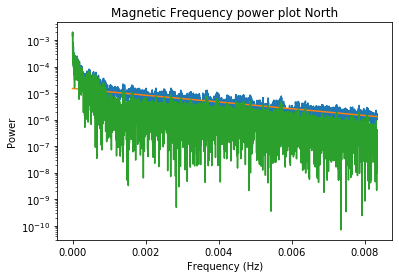

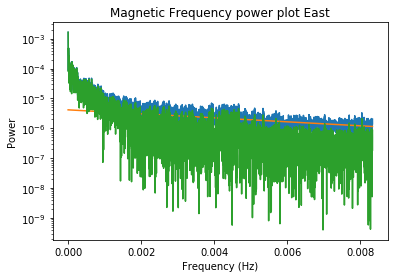

In [83]:
from scipy.optimize import curve_fit
df=1./(24*60*60*3.*3) # seconds! #aangepast
fmax=1./(2*60.)
freqvec=np.arange(0,fmax+df,df)
n=len(freqvec)
newxsignal=np.zeros((len(newMXft_matrix),len(newMXft_matrix[0])), dtype='complex')
newysignal=np.zeros((len(newMYft_matrix),len(newMYft_matrix[0])), dtype='complex')

a,b=curve_fit(func, freqvec[2*int(n/3):], 2*np.sum(abs(newMXft_matrix[2*int(n/3):]), axis=1)/len(newMXft_matrix))
print(a)
c,d=curve_fit(func, freqvec[2*int(n/3):], 2*np.sum(abs(newMYft_matrix[2*int(n/3):]), axis=1)/len(newMYft_matrix))
print(c)
value1=filt(2*np.sum(abs(newMXft_matrix), axis=1)/len(newMXft_matrix),freqvec,a[0],a[1])
value2=filt(2*np.sum(abs(newMYft_matrix), axis=1)/len(newMYft_matrix),freqvec,*c)
for i in range(len(newMXft_matrix[0])):
    newxsignal[:,i]=newMXft_matrix[:,i]*value1
    newysignal[:,i]=newMYft_matrix[:,i]*value2

fig=plt.figure()
ax=fig.add_subplot()
ax.clear()
ax.set_title("Magnetic Frequency power plot North")
ax.set_ylabel("Power")
ax.set_xlabel("Frequency (Hz)")
# for item in range(len(MX_matrix[0])):
ax.plot(freqvec,2*np.sum(abs(newMXft_matrix), axis=1)/len(newMXft_matrix))
ax.plot(freqvec,func(freqvec, *a))
ax.plot(freqvec,2*np.sum(abs(newxsignal), axis=1)/len(newxsignal))
plt.yscale('log')
# ax.set_xlim(0,0.001)
# plt.plot()
plt.savefig('/nobackup/users/out/Magnetic_field/Halloween/Frequency_power_plot_Northern_field.png')

fig2=plt.figure()
ax2=fig2.add_subplot()
ax2.clear()
ax2.set_title("Magnetic Frequency power plot East")
ax2.set_ylabel("Power")
ax2.set_xlabel("Frequency (Hz)")
# for item in range(len(MX_matrix[0])):
ax2.plot(freqvec,2*np.sum(abs(newMYft_matrix), axis=1)/len(newMYft_matrix))
ax2.plot(freqvec,func(freqvec, *c))
ax2.plot(freqvec,2*np.sum(abs(newysignal), axis=1)/len(newysignal))
plt.yscale('log')
# ax2.set_xlim(0,0.001)
# plt.plot()
plt.savefig('/nobackup/users/out/Magnetic_field/Halloween/Frequency_power_plot_Eastern_field.png')

# fig=plt.figure()
# ax=fig.add_subplot()
# ax.clear()
# ax.set_title("Frequency power plot North")
# ax.set_ylabel("Power")
# ax.set_xlabel("Frequency (Hz)")
# # for item in range(len(MX_matrix[0])):
# ax.plot(freqvec,2*np.sum(abs(EXft_matrix), axis=1)/len(EXft_matrix))
# plt.yscale('log')
# # ax.set_xlim(0,0.001)
# plt.plot()
# # plt.savefig('/nobackup/users/out/Magnetic_field/Halloween/Frequency_power_plot_Northern_field.png')

# fig2=plt.figure()
# ax2=fig2.add_subplot()
# ax2.clear()
# ax2.set_title("Frequency power plot East")
# ax2.set_ylabel("Power")
# ax2.set_xlabel("Frequency (Hz)")
# # for item in range(len(MX_matrix[0])):
# ax2.plot(freqvec,2*np.sum(abs(EYft_matrix), axis=1)/len(EYft_matrix))
# plt.yscale('log')
# # ax2.set_xlim(0,0.001)
# plt.plot()
# # plt.savefig('/nobackup/users/out/Magnetic_field/Halloween/Frequency_power_plot_Eastern_field.png')

In [60]:
def func(x,a,b):
    return b*10 ** (a*x)
def filt(PSD,x,a,b):
    S=PSD-(b*10 ** (a*x))
    return S/PSD

In [21]:
print(len(MX_matrix[0]))

14965


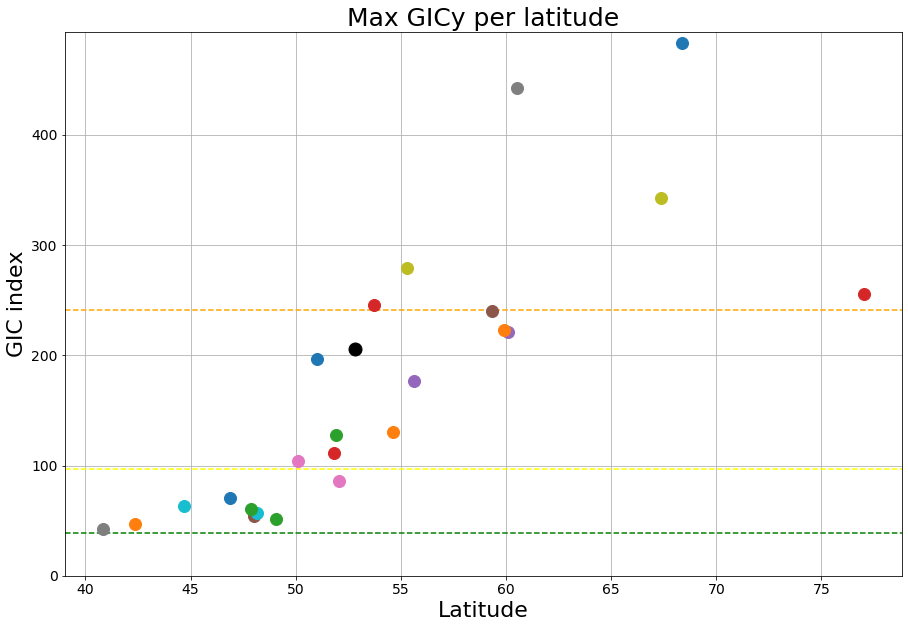

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
newfile=pd.read_csv('/nobackup/users/out/Magnetic_field/Tozzi_merged/GIC_index.txt', delimiter=' ', header=None)
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot()
maxi=0
factor=[2,5,8,6,9,9,10,22,11,5,5,6,4,2,2,5,3,2,2,6,7,5,6,6,4]
os.system(f'ls /usr/people/out/Documents/Magnetic_field/magnetic_data/Tozzi/23-10-2003_Tozzi/ > /nobackup/users/out/Magnetic_field/Tozzi_merged/temp.txt') #get coordinates
f=open(f'/nobackup/users/out/Magnetic_field/Tozzi_merged/temp.txt')
string2=[]
for item in f:
    item=item.strip("\n")
    string2.append(item)
string2=sorted(string2)
lat=np.zeros(len(string2))
lon=np.zeros(len(string2))
stat=[]
for counter2,item in enumerate(string2):
    File=open(f'/usr/people/out/Documents/Magnetic_field/magnetic_data/Tozzi/23-10-2003_Tozzi/{item}')
    for counter,line in enumerate(File):
        if counter==3:
            words=line.split()
            stat.append(words[2])
os.system(f'rm /nobackup/users/out/Magnetic_field/Tozzi_merged/temp.txt')
plt.rcParams.update({'font.size': 14})             
ax.set_title('Max GICy per latitude',fontsize=25)

ax.set_ylabel('GIC index', fontsize=22)
ax.set_xlabel('Latitude', fontsize=22)
# ax.axhline(16, linestyle='--', color='green')#, label='5%')
# ax.axhline(43, linestyle='--', color='yellow')#, label='35%')
# ax.axhline(114, linestyle='--', color='orange')#, label='65%')
# ax.axhline(304, linestyle='--', color='red')#, label='95%')
ax.axhline(39, linestyle='--', color='green')#, label='5%')
ax.axhline(97, linestyle='--', color='yellow')#, label='35%')
ax.axhline(241, linestyle='--', color='orange')#, label='65%')
ax.axhline(600, linestyle='--', color='red')#, label='95%')
for line in range(len(newfile)):
    if newfile.iloc[line,1] > 52.8 and newfile.iloc[line,1] < 52.9:
        ax.plot(newfile.iloc[line,1],newfile.iloc[line,3], 'o',label=f'{stat[line]} (%.1f)'%newfile.iloc[line,1], markersize=13, color='black')
    else:
        ax.plot(newfile.iloc[line,1],newfile.iloc[line,3], 'o',label=f'{stat[line]} (%.1f)'%newfile.iloc[line,1], markersize=12)
    if maxi < newfile.iloc[line,3]:
        maxi = newfile.iloc[line,3]
# ax.legend(bbox_to_anchor=(0.94,0.5),loc='center right')
ax.set_ylim(0,maxi+10)
ax.grid()
# plt.plot()
plt.savefig('/nobackup/users/out/Magnetic_field/Tozzi_merged/GICy_lat.png')

In [5]:
### get plot of maximum GIC ###
import os
import pandas as pd
import numpy as np
netpath='/usr/people/out/Documents/topology_4'
respath='/nobackup/users/out/Magnetic_field/new_Halloween'

os.system(f'ls {respath}/GIC/*.csv > {respath}/temp.txt')
f=open(f'{respath}/temp.txt')
string=[]
for item in f:
    item=item.strip('\n')
    string.append(item)
string=sorted(string)
f.close()
os.system(f'rm {respath}/temp.txt')
GIC=np.zeros((1440*3,8))
GICmax=np.zeros(8)
lon=np.zeros(8)
lat=np.zeros(8)
GICMAX=1
f=open(f'{respath}/maxGIC.txt', 'w+')
for counter,item in enumerate(string):
    newfile=pd.read_csv(item, delimiter=';')
    GIC[counter,:]=newfile['GIC']
lon=newfile['lon']
lat=newfile['lat']
for item in range(len(GIC[0])):
    A=max(GIC[:,item])
    B=min(GIC[:,item])
    if A>abs(B):
        f.write(f'{lon[item]} {lat[item]} {A} {abs(A)/GICMAX}\n')
    else:
        f.write(f'{lon[item]} {lat[item]} {B} {abs(B)/GICMAX}\n')
f.close()

lim1=3.3
lim2=7.5
lim3=50.5
lim4=54
# lim1=18
# lim2=30
# lim3=59
# lim4=76.5
title=f'Maximum GIC at Halloween'
proj='-JM15C -P'
lims=f'-R{lim1}/{lim2}/{lim3}/{lim4}'
psfile=f'{respath}/GICmax.ps' #aanpassen
pdffile=f'{respath}/GICmax.pdf' #aanpassen
os.system(f'gmt pscoast {proj} {lims} -W0.5p -K -Ggrey -Slightblue -Df -N1/0.25p> {psfile}' )
os.system(f'gmt psbasemap {proj} {lims} -Ba1g1 -BWeSn+t"{title}" -O -K>> {psfile}' )
os.system(f'gmt psxy {netpath}/cables.csv {proj} {lims} -W0.5p -Wred -O -K>> {psfile}' )
os.system(f'gmt psxy {respath}/maxGIC.txt {proj} {lims} -Ctopo.cpt -Scc -O -K>> {psfile}')    
os.system(f'gmt psxy {netpath}/legend.txt {proj} {lims} -Ctopo.cpt -W -Scc -O -K>> {psfile}')
os.system(f'gmt pstext {netpath}/legendtext.txt {proj} {lims} -F+f30pHelvetica,black -O>> {psfile}')
os.system(f'ps2pdf {psfile} {pdffile}')
os.system(f'rm {psfile}')

0

/usr/people/out/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


[3.14518455e-02 3.06240238e-02 3.00516914e-02 ... 7.47225569e-07
 5.43798176e-07 3.18829709e-07]
[786.63487003 556.23485091 454.16385396 ...   9.77355862   9.77280434
   9.77205024]


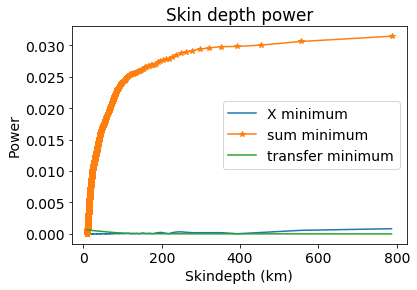

In [44]:
# get skindepth power spectrum from magnetic field
import matplotlib.pyplot as plt
import numpy as np
# from scipy.integrate import quad

def skindepth(freq,S):
    if freq==0:
        return 0
    else:
        mu=4*np.pi*10**-7
        return 1./np.sqrt(abs(freq)*mu*S)

df=1./(24*60*60*3.*3) # seconds! #aangepast
fmax=1./(2*60.)
freqvec=np.arange(df,fmax+df,df) 
skin1=np.zeros(len(freqvec))
skinrev=np.zeros(len(freqvec))
skin2=np.zeros(len(freqvec))
trans=np.zeros(len(freqvec))
integral=np.zeros(len(freqvec))
for counter,item in enumerate(freqvec):
    skin1[counter]=skindepth(item,10**0)
    skinrev[len(freqvec)-counter-1]=skindepth(item,10**0)
#     skin2[counter]=skindepth(item,10**-3)
    trans[counter]=transferfunction(item,7)
    integral[counter]=np.sum(2*abs(newMXft_matrix[counter+1:,9719]))
    
fig=plt.figure()
ax=fig.add_subplot()
ax.set_title('Skin depth power')
ax.set_ylabel('Power')
ax.set_xlabel('Skindepth (km)')

ax.plot(skin1/1000, 2*abs(newMXft_matrix[1:,9719]), label='X minimum')
# ax.plot(skin1/1000, 2*np.sum(abs(newMXft_matrix[1:,9719]), axis=1), label='X minimum')
ax.plot(skin1/1000, integral, label='sum minimum', marker='*')
ax.plot(skin1/1000, abs(trans)/200000, label='transfer minimum')
# ax.set_ylim(0,0.0005)
# ax.plot(skin2/1000, 2*np.sum(abs(newMXft_matrix[1:,:]), axis=1)/len(newMXft_matrix[1:,:]), label='maximum')
ax.legend()
plt.plot()
print(integral)
print(skin1/1000)

/usr/people/out/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


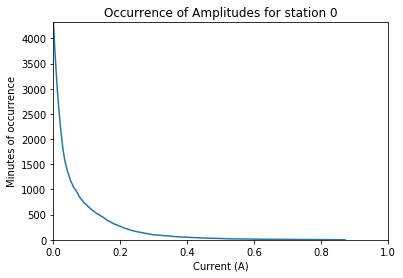

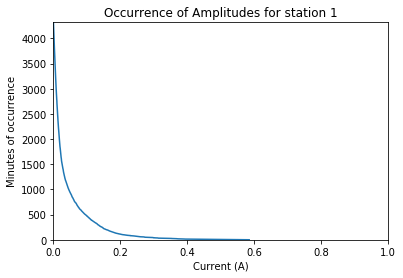

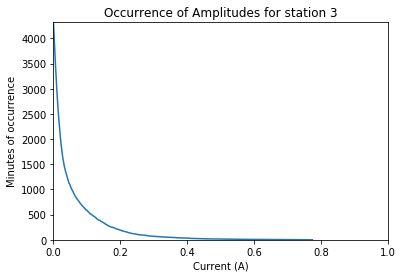

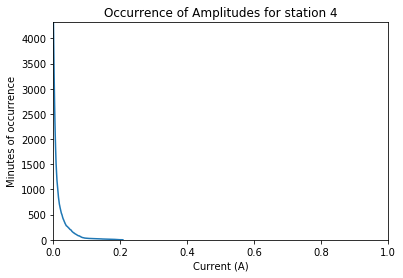

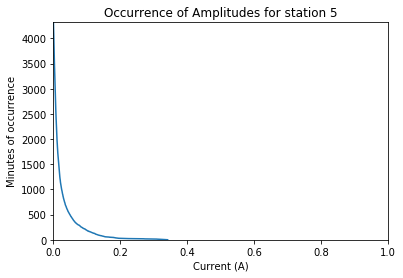

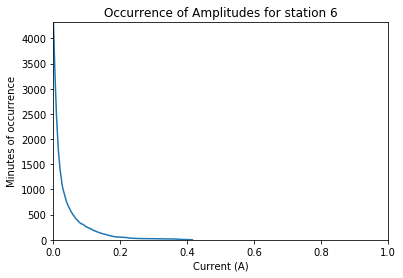

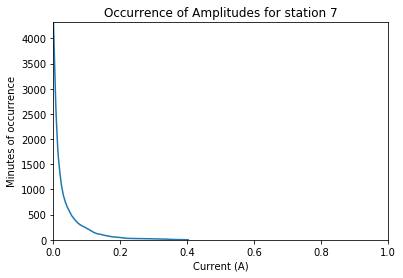

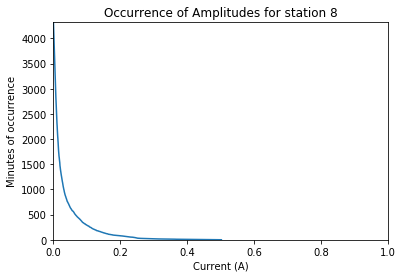

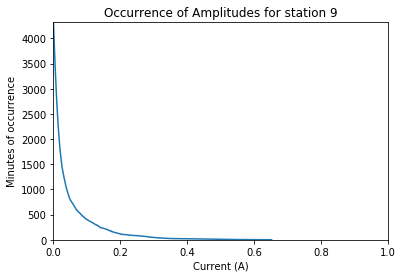

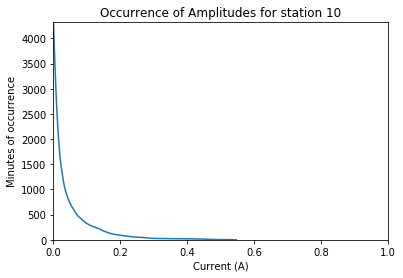

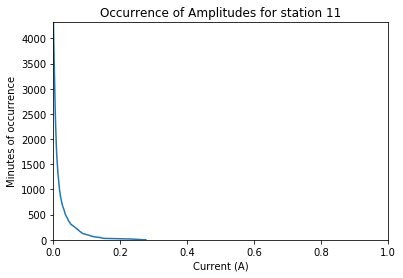

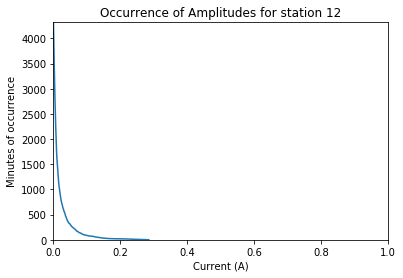

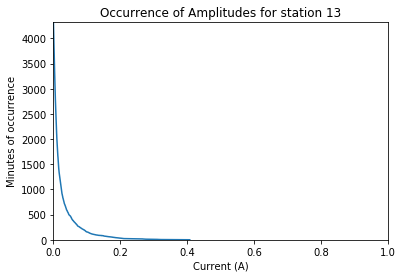

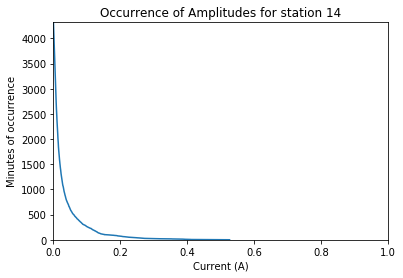

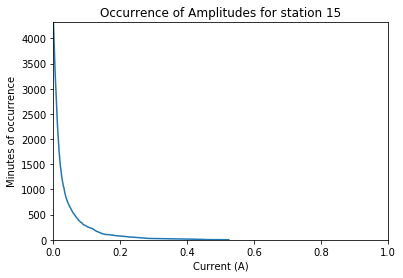

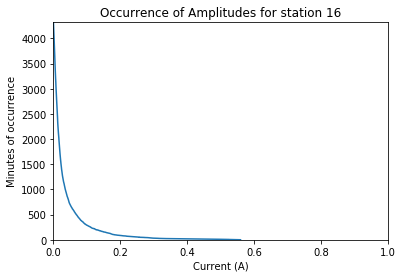

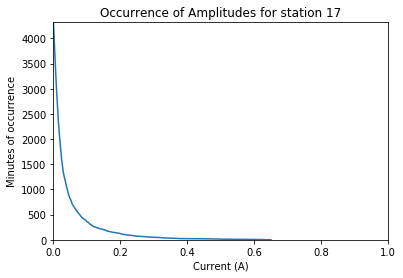

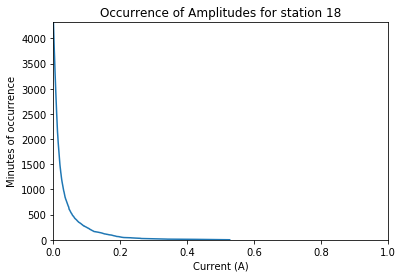

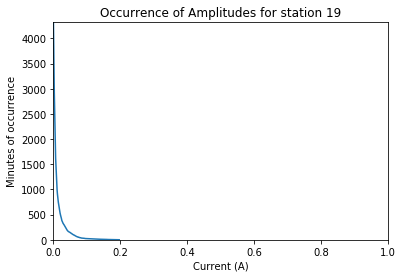

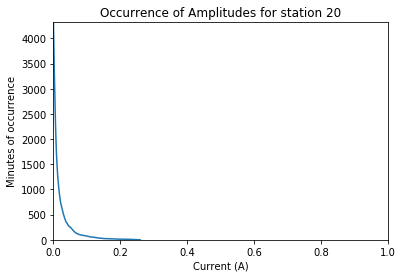

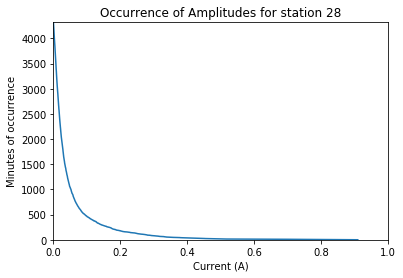

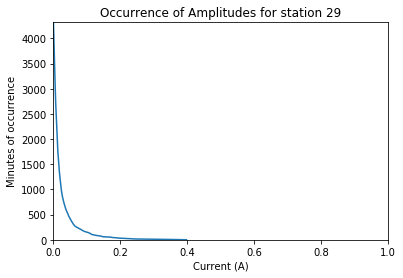

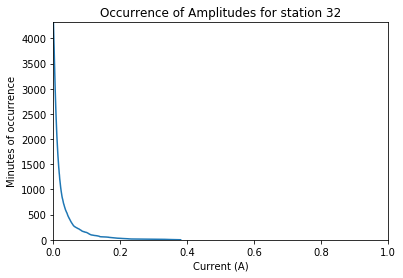

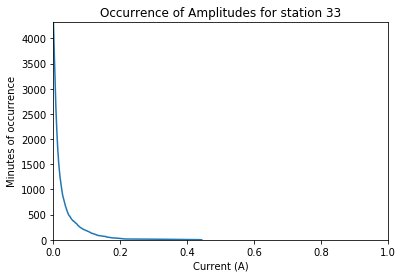

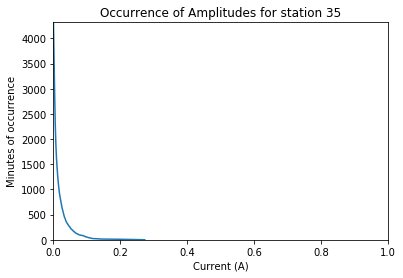

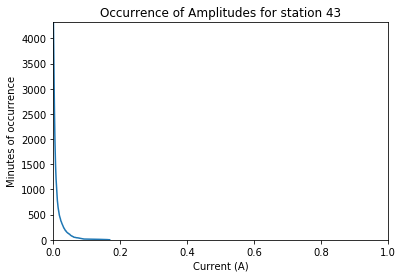

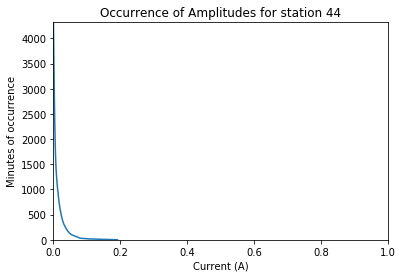

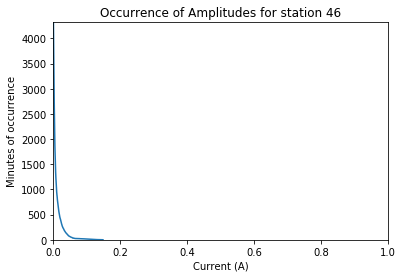

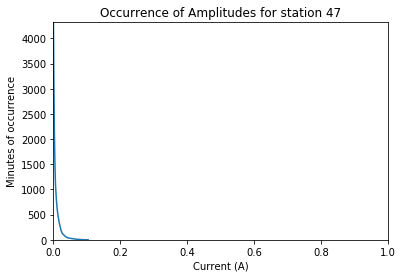

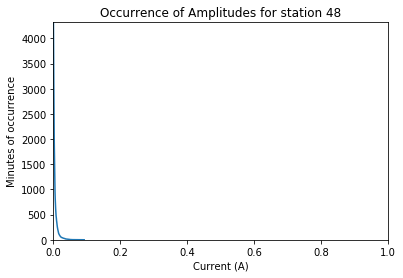

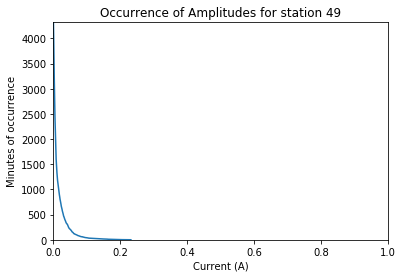

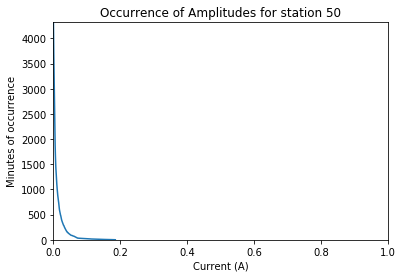

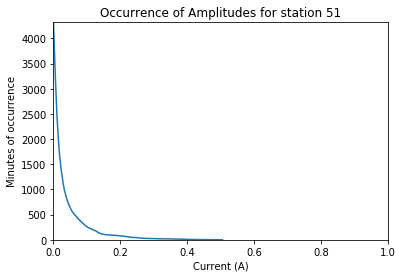

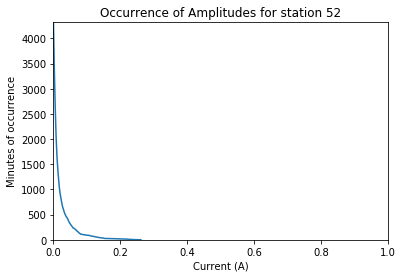

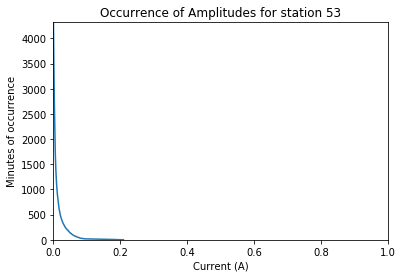

In [4]:
# how long has a certain station a certain amount of amperes
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

A=np.arange(3,21)
B=np.arange(46,54,1)
stationlist=np.hstack([0,1,A,28,29,32,33,35,43,44,B])
netpath='/usr/people/out/Documents/380+220kV_extended'
respath='/nobackup/users/out/Magnetic_field/Halloween/model7_filt'
# fig=plt.figure(figsize=(15,10))
# ax=fig.add_subplot()
# ax.set_title('Occurence of GICs per station')
# ax.set_ylabel('minutes')
# ax.set_xlabel('station number')
for counter4,station in enumerate(stationlist):
    A2=0
    A4=0
    A6=0
    A8=0
    sorting=np.zeros(1440*3)
    sortingx=[]
    sortingy=[]
    
    os.system(f'ls {respath}/GIC/*.csv > {respath}/temp.txt')
    f=open(f'{respath}/temp.txt')
    string=[]
    for item in f:
        item=item.strip('\n')
        string.append(item)
    string=sorted(string) 
    f.close()
    os.system(f'rm {respath}/temp.txt')
    GIC=np.zeros((1440*3,149))

    for counter,item in enumerate(string):
        newfile=pd.read_csv(item, delimiter=';')
        GIC[counter,:]=newfile['GIC']
    sorting=sorted(abs(GIC[:,counter4]))
    for counter in range(len(sorting)-1):
        if sorting[counter]!=sorting[counter+1]:
            sortingx.append(sorting[counter])
            if counter==1440*3-1:
                sortingx.append(sorting[counter+1])
    for counter in range(len(sortingx)):
        sortingy.append(len(sortingx)-counter)
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_title(f'Occurrence of Amplitudes for station {station}')
    ax.set_ylabel('Minutes of occurrence')
    ax.set_xlabel('Current (A)')
    ax.plot(sortingx,sortingy)
    ax.set_ylim(0,sortingy[0])
    ax.set_xlim(0,1)
    plt.plot()
#     for item in range(len(GIC)):
#         if abs(GIC[item,station])>0.2:
#             A2+=1
#             if abs(GIC[item,station])>0.4:
#                 A4+=1
#                 if abs(GIC[item,station])>0.6:
#                     A6+=1
#                     if abs(GIC[item,station])>0.8:
#                         A8+=1
#     if station==0:
# #         ax.plot(counter4,A2, 'o',color='green',  label='0.2 A')
#         ax.plot(counter4,A4, 'o',color='yellow',  label='0.4 A')
#         ax.plot(counter4,A6, 'o',color='orange',  label='0.6 A')
#         ax.plot(counter4,A8, 'o',color='red',  label='0.8 A')
#     else:
# #         ax.plot(counter4,A2, 'o', color='green')
#         ax.plot(counter4,A4, 'o', color='yellow')
#         ax.plot(counter4,A6, 'o', color='orange')
#         ax.plot(counter4,A8, 'o', color='red')
# ax.legend()
# plt.savefig(f'{respath}/GICoccurrence.png')
#     print(f'station {station} is {A8} minutes above 0.8 A \n {A6} minutes above 0.6 A \n {A4} minutes above 0.4 A \n {A2} minutes above 0.2 A \n')

In [52]:
class GIC: 
    # __init__ sets basic path for location:
    # netpath: path to folder where powernetwork csv files are
    # statpath: path to folder where unpacked data stations are for GIC calculation
    # respath: path to where results need to be written
    # day: day for GIC calculation given as dd-mm-yyyy
    # quietday:path to folder where unpacked data stations are quiet reference day for GIC calculation,
    # found by the website of Potzdam: ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/quietdst/
    def __init__(self,netpath,statpath,respath,day,quietpath):      
        self.netpath=netpath
        self.statpath=statpath
        self.respath=respath
        self.day=day
        self.quiet=quietpath
        try:
            daysplit=self.day.split('-')
            self.dayvar=f'{daysplit[2]}-{daysplit[1]}-{daysplit[0]}' #get day string in reverse order, so yyyy-mm-dd
        except:
            pass
        #create topomap for plotting GICs in correct colour, blue is into network, red is into ground
        f=open("topo.cpt","w+")
        f.write("-10000 0/0/100 0 0/0/100\n")
        f.write("0 100/0/0 10000 100/0/0")
        f.close()
    
    def newplotspace(self,activeday,quietday,figures=False,plots=True):
        #import needed packages
        import os
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        import re
        from chaosmagpy.data_utils import mjd2000
        possible_characters = ('-', ' ')
    ##### calculate values from observation station #####
        # read-in file of station
        File=open(f'{self.quiet}/{quietday}','r') # open file
        HorX=[] # make some lists
        DeclY=[]
        VertZ=[]
        X2=[]
        for counter,line in enumerate(File):
            words=line.split()
            if words[0]=='DATE':
                datastart=counter+2
                for counter2,letters in enumerate(words[3]):
                    if counter2==3:
                        if letters=='H':
                            types=False
                            break
                        if letters=='X':
                            types=True
                            break
        File=open(f'{self.quiet}/{quietday}','r')
        counter=0
        for counter,line in enumerate(File):
            if counter==2:
                words=line.split()
                station=words[2]
            if counter==4:
                words=line.split()
                lat=float(words[2]) # latitude station
            if counter==5:
                words=line.split()
                lon=float(words[2]) # longitude station
                
            if counter>=datastart-1: #read when the data starts
                words=line.split()
                if counter==datastart:
                    for newcounter,letters in enumerate(words[1]):
                        if newcounter==4:
                            if letters=='1':
                                minutes=True
                            else:
                                minutes=False
                
                if float(words[3])>90000: #then no data is saved, but previous sample or zero is stored
                    if counter==datastart-1:
                        HorX.append(0)
                    else:
                        HorX.append(HorX[-1]) # get horizontal or X-component
                else:
                    HorX.append(float(words[3]))

                if float(words[4])>90000:
                    if counter==datastart-1:
                        DeclY.append(0)
                    else:
                        DeclY.append(DeclY[-1]) # get 'declination' or Y-component
                else:
                    DeclY.append(float(words[4]))

                if float(words[5])>90000:
                    if counter==datastart-1:
                        VertZ.append(0)
                    else:
                        VertZ.append(VertZ[-1]) # get vertical component or Z-component
                else:
                    VertZ.append(float(words[5]))
            
        File.close()

        if types: #if given in XYZ, types==true
            X2=HorX
            Y2=DeclY
            Z2=VertZ

        else: #if given in HDZ, types==false
            for item in range(len(DeclY)):
                X2.append(np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
            Y2=DeclY
            Z2=VertZ

        File=open(f'{self.statpath}/{activeday}','r') # open file
        HorX=[] # make some lists
        DeclY=[]
        VertZ=[]
        X1=[]
        N=0
        for counter,line in enumerate(File):
            words=line.split()
            if words[0]=='DATE':
                datastart=counter+2
                for counter2,letters in enumerate(words[3]):
                    if counter2==3:
                        if letters=='H':
                            types=False
                            break
                        if letters=='X':
                            types=True
                            break
        File=open(f'{self.statpath}/{activeday}','r')
        counter=0
        for counter,line in enumerate(File):
            if counter==2:
                words=line.split()
                station=words[2]
            if counter==4:
                words=line.split()
                lat=float(words[2]) # latitude station
            if counter==5:
                words=line.split()
                lon=float(words[2]) # longitude station
            if counter>=datastart-1: #read when the data starts
                N+=1
                if counter==datastart-1:
                    dates=re.split("[%s]" % ("".join(possible_characters)), line) # get start date

                words=line.split()
                if float(words[3])>90000: #then no data is saved, but previous sample or zero is stored
                    if counter==datastart-1:
                        HorX.append(0)
                    else:
                        HorX.append(HorX[-1]) # get horizontal or X-component
                else:
                    HorX.append(float(words[3]))

                if float(words[4])>90000:
                    if counter==datastart-1:
                        DeclY.append(0)
                    else:
                        DeclY.append(DeclY[-1]) # get 'declination' or Y-component
                else:
                    DeclY.append(float(words[4]))

                if float(words[5])>90000:
                    if counter==datastart-1:
                        VertZ.append(0)
                    else:
                        VertZ.append(VertZ[-1]) # get vertical component or Z-component
                else:
                    VertZ.append(float(words[5]))

        File.close()
        try:
            os.mkdir(f'{self.respath}/{self.day}')
        except Exception:
            pass
        try:
            os.mkdir(f'{self.respath}/{self.day}/{station}_{dates[0]}-{dates[1]}-{dates[2]}')
        except Exception:
            pass

        if types: #if given in XYZ, types==true
            X1=HorX
            Y1=DeclY
            Z1=VertZ

        else: #if given in HDZ, types==false
            for item in range(len(DeclY)):
                X1.append(np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
            Y1=DeclY
            Z1=VertZ
    ##### calculate model value of magnetic field #####
        # set up
        if int(dates[2])==31:
            if int(dates[1])==12:
                time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])), 
                                   mjd2000(int(dates[0])+1,1,1), num=N)
            else:
                time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])), 
                                   mjd2000(int(dates[0]),int(dates[1])+1,1), num=N)
        else:
            time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])),
                               mjd2000(int(dates[0]),int(dates[1]),int(dates[2])+1), num=N)

    ##### subtract the two data sets! #####
        SpaceX=np.subtract(X1,X2)
        SpaceY=np.subtract(Y1,Y2)
        SpaceZ=np.subtract(Z1,Z2)

    ##### plot data #####
        if figures:
            figx=plt.figure(figsize=(20,10))
            ax1=figx.add_subplot(311)
            ax11=figx.add_subplot(312)
            ax12=figx.add_subplot(313)
            ax1.set_title('$B_\\theta$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
            ax12.set_xlabel('time (days after 1 jan 2000)')
            ax11.set_ylabel('$B_\\theta$ (nt)')
            ax11.plot(time,X1,label='observed',color='blue')
            ax12.plot(time,X2,label='model',color='green')
            ax1.plot(time,SpaceX,label='residue',color='red')
            ax1.legend()
            ax11.legend()
            ax12.legend()

            figy=plt.figure(figsize=(20,10))
            ax2=figy.add_subplot(311)
            ax21=figy.add_subplot(312)
            ax22=figy.add_subplot(313)
            ax2.set_title('$B_\\phi$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
            ax22.set_xlabel('time (days after 1 jan 2000)')
            ax21.set_ylabel('$B_\\phi$ (nt)')
            ax21.plot(time,Y1,label='total',color='blue')
            ax22.plot(time,Y2,label='model',color='green')
            ax2.plot(time,SpaceY,label='residue',color='red')
            ax2.legend()
            ax21.legend()
            ax22.legend()

            figz=plt.figure(figsize=(20,10))
            ax3=figz.add_subplot(311)
            ax31=figz.add_subplot(312)
            ax32=figz.add_subplot(313)
            ax3.set_title('$B_r$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
            ax32.set_xlabel('time (days after 1 jan 2000)')
            ax31.set_ylabel('$B_r$ (nt)')
            ax31.plot(time,Z1,label='total',color='blue')
            ax32.plot(time,Z2,label='model',color='green')
            ax3.plot(time,SpaceZ,label='residue',color='red')
            ax3.legend()
            ax31.legend()
            ax32.legend()
            plt.show()

        if plots:
            figall=plt.figure(figsize=(20,10))
            ax4=figall.add_subplot(311)
            ax41=figall.add_subplot(312)
            ax42=figall.add_subplot(313)
            ax4.set_title('Radial component')
            ax41.set_title('Longitudinal component')
            ax41.set_ylabel('nanoteslas')
            ax42.set_title('Latitudional component')
            ax4.plot(time,SpaceZ,color='red')
            ax41.plot(time,SpaceY,color='red')
            ax42.plot(time,SpaceX,color='red')
            plt.savefig(f'{self.respath}/{self.day}/{station}_{dates[0]}-{dates[1]}-{dates[2]}/SWresult.png')

    ##### calculate frequency spectrum #####
        # try to get time derivative, only horizontal components matter
        dXdt=np.zeros(len(SpaceX)) # define length array
        dYdt=np.zeros(len(SpaceY))

        for item in range(len(SpaceX)-1): # obtain derivative
            dXdt[item]=SpaceX[item+1]-SpaceX[item]
            dYdt[item]=SpaceY[item+1]-SpaceY[item]

        if plots:
            figx=plt.figure()
            ax1=figx.add_subplot()
            ax1.set_title('d$B_X$/dt at ' + station)
            ax1.set_xlabel('time (days after 1 jan 2000)')
            if minutes:
                ax1.set_ylabel(f'd$B_X$/dt (nt/min)')
            else:
                ax1.set_ylabel(f'd$B_X$/dt (nt/s)')
            ax1.plot(time,dXdt,label='residue',color='red')
            ax1.legend()
            plt.savefig(f'{self.respath}/{self.day}/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtX.png')

            figy=plt.figure()
            ax2=figy.add_subplot()
            ax2.set_title('d$B_Y$/dt at ' + station)
            ax2.set_xlabel('time (days after 1 jan 2000)')
            if minutes:
                ax1.set_ylabel(f'd$B_Y$/dt (nt/min)')
            else:
                ax1.set_ylabel(f'd$B_Y$/dt (nt/s)')
            ax2.plot(time,dYdt,label='residue',color='red')
            ax2.legend()

            plt.savefig(f'{self.respath}/{self.day}/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtY.png')

        ### horizontal component ###
        Hor_comp=np.sqrt(SpaceX**2+SpaceY**2)
        dHdt=np.zeros(len(Hor_comp))
        for item in range(len(Hor_comp)-1): # obtain derivative
            dHdt[item]=Hor_comp[item+1]-Hor_comp[item]

        figH=plt.figure()
        ax1=figH.add_subplot(211)
        ax1.set_title('horizontal component at ' + station)
        ax1.set_xlabel('time')
        ax1.set_ylabel('nT')
        ax1.plot(time,Hor_comp,color='red')
        ax2=figH.add_subplot(212)
        ax2.set_xlabel('time')
        if minutes:
            ax2.set_ylabel('nT/min')
        else:
            ax2.set_ylabel('nT/s')
        ax2.plot(time,dHdt,color='red')
        plt.savefig(f'{self.respath}/{self.day}/{station}_{dates[0]}-{dates[1]}-{dates[2]}/Horizontal_data.png')

    # ##### save files #####
        newfile=pd.DataFrame(columns=['B_theta (nt)','B_phi (nt)','B_r (nt)','B_H','dBx/dt','dBy/dt','dBH/dt'])
        newfile['B_theta (nt)']=SpaceX
        newfile['B_phi (nt)']=SpaceY
        newfile['B_r (nt)']=SpaceZ
        newfile['B_H']=Hor_comp
        newfile['dBx/dt']=dXdt
        newfile['dBy/dt']=dYdt
        newfile['dBH/dt']=dHdt
        newfile.to_csv(path_or_buf=f'{self.respath}/{self.day}/{station}_{dates[0]}-{dates[1]}-{dates[2]}/allresults.csv', sep=';', index=False, header=True)
        plt.close('all')

In [53]:
Halloween=GIC('/usr/people/out/Documents/380+220kV_extended','/usr/people/out/Documents/Magnetic_field/magnetic_data/sec_17-03-2015','/nobackup/users/out/Magnetic_field','sec_17-03-2015','/usr/people/out/Documents/Magnetic_field/magnetic_data/sec_10-03-2015')
Halloween.newplotspace('ler20150317psec.sec','ler20150310psec.sec')

In [3]:
def BtoE(model,run,scaling=1):                        
    import numpy as np
    import os
    from multiprocessing import Process
    import pandas as pd
    from threading import local
    import logging
    localvar=local()
    respath='/nobackup/users/out/Magnetic_field'
    day='min_17-03-2015'
    samples=60*24
    
    # import magnetic field data in X/Y-direction (north)
    magnetic_Xfiles=[]
    magnetic_Yfiles=[]

    ############################# get the strings ###################################
    for numbers in range(int(60*run),int(60*(run+1)),1):
        os.system(f"ls {respath}/{day}/interpolation/minute_{str(numbers).zfill(4)}.csv >> {respath}/{day}/tempX.txt")
        os.system(f"ls {respath}/{day}/interpolation/minute_{str(numbers).zfill(4)}.csv.Y >> {respath}/{day}/tempY.txt")
    f=open(f'{respath}/{day}/tempX.txt')
    for item in f:
        item=item.strip('\n')
        magnetic_Xfiles.append(item)
    f.close()
    os.system(f'rm {respath}/{day}/tempX.txt')
    f=open(f'{respath}/{day}/tempY.txt')
    for item in f:
        item=item.strip('\n')
        magnetic_Yfiles.append(item)
    f.close()
    os.system(f'rm {respath}/{day}/tempY.txt')

    magnetic_Xfiles=sorted(magnetic_Xfiles) #sort to number 0000-1440 or 86400
    magnetic_Yfiles=sorted(magnetic_Yfiles)

    for file in magnetic_Xfiles:
        Xfile=pd.read_csv(file, delimiter=' ', header=None)
        break
    for file in magnetic_Yfiles:
        Yfile=pd.read_csv(file, delimiter=' ', header=None)
        break

    lat=np.zeros(len(Xfile))
    lon=np.zeros(len(Xfile))
    MX_matrix=np.zeros((len(magnetic_Xfiles),len(Xfile)))#matrix for storing values (vertical same place, horizontal same time)
    MX_parz=np.zeros((3*len(magnetic_Xfiles),len(Xfile)))
    MXft_matrix=np.zeros((int(3*len(magnetic_Xfiles)/2)+1,len(Xfile)),dtype='complex')
    EX_matrix=np.zeros((len(magnetic_Yfiles),len(Yfile)))
    EX_parz=np.zeros((3*len(magnetic_Yfiles),len(Yfile)))
    EXft_matrix=np.zeros((int(3*len(magnetic_Yfiles)/2)+1,len(Yfile)),dtype='complex')
    MY_matrix=np.zeros((len(magnetic_Yfiles),len(Yfile))) #matrix for storing values (vertical same place, horizontal same time)
    MY_parz=np.zeros((3*len(magnetic_Yfiles),len(Yfile)))
    MYft_matrix=np.zeros((int(3*len(magnetic_Yfiles)/2)+1,len(Yfile)),dtype='complex')
    EY_matrix=np.zeros((len(magnetic_Xfiles),len(Xfile)))
    EY_parz=np.zeros((3*len(magnetic_Xfiles),len(Xfile)))
    EYft_matrix=np.zeros((int(3*len(magnetic_Xfiles)/2)+1,len(Xfile)),dtype='complex')
    print(len(MXft_matrix))
    ################################################################################# 
    ########################### get the values ######################################
    ######################### first x-direction #####################################
    print('setting up matrices!')
    for counter,file in enumerate(magnetic_Xfiles):
        Xfile=pd.read_csv(file, delimiter=' ', header=None)
        values=Xfile.to_numpy()
        MX_matrix[counter,:]=values[:,2]/(10**9)*scaling #scaling factor
    lat=values[:,1]
    lon=values[:,0]
    for counter,file in enumerate(magnetic_Yfiles):
        Yfile=pd.read_csv(file, delimiter=' ', header=None)
        values=Yfile.to_numpy()
        MY_matrix[counter,:]=values[:,2]/(10**9)*scaling

    ############## start fourier transformation ######################
    print('starting fourier transformation')

# try Parzen window now
    MX_parz[0:len(magnetic_Xfiles),:]=MX_matrix[0,:]
    MX_parz[2*len(magnetic_Xfiles):,:]=MX_matrix[-1,:]
    MX_parz[len(magnetic_Xfiles):2*len(magnetic_Xfiles),:]=MX_matrix
    MY_parz[0:len(magnetic_Yfiles),:]=MY_matrix[0,:]
    MY_parz[2*len(magnetic_Yfiles):,:]=MY_matrix[-1,:]
    MY_parz[len(magnetic_Yfiles):2*len(magnetic_Yfiles),:]=MY_matrix
    for column in range(len(MX_matrix[0])):
        MXft_matrix[:,column]=np.fft.rfft(MX_parz[:,column]*Parzen(len(MX_parz))) #multiply with hanning window to reduce edge effects
    for column in range(len(MY_matrix[0])):
        MYft_matrix[:,column]=np.fft.rfft(MY_parz[:,column]*Parzen(len(MY_parz)))

    ######################### calculate Electric field in frequency direction #############################3
    # make frequencyvector in seconds
    df=1./(60*60.*3) # seconds! #aangepast
    fmax=1./(2*60)
    freqvec=np.arange(0,fmax+0.5*df,df) 
    print(freqvec, len(freqvec))
    #filter signal for noise
    MXft_matrix=filt(freqvec,MXft_matrix)
    MYft_matrix=filt(freqvec,MYft_matrix)

    # t3_start=process_time() #1d conductivity model!
    for row in range(1,len(MXft_matrix)): #zero is not allowed, same row = same frequency
        EYft_matrix[row,:]=-1*MXft_matrix[row,:]*transferfunction(freqvec[row],model)
    for row in range(1,len(MYft_matrix)): #zero is not allowed
        EXft_matrix[row,:]=MYft_matrix[row,:]*transferfunction(freqvec[row],model)

    ######################## fourier transform back ####################################
    # t4_start=process_time()
    for column in range(len(EYft_matrix[0])):
        EY_parz[:,column]=np.fft.irfft(EYft_matrix[:,column])
    for column in range(len(EXft_matrix[0])):
        EX_parz[:,column]=np.fft.irfft(EXft_matrix[:,column])

    EX_matrix=EX_parz[len(magnetic_Xfiles):2*len(magnetic_Xfiles),:]
    EY_matrix=EY_parz[len(magnetic_Yfiles):2*len(magnetic_Yfiles),:]

    del MX_matrix, MX_parz, MXft_matrix, EX_parz, EXft_matrix, MY_matrix, MY_parz, MYft_matrix, EY_parz, EYft_matrix
    ######################### writing E field to files #################################
    # t5_start=process_time()
    try:
        os.mkdir(f'{respath}/{day}/electric_field_east')
    except:
        logging.warning('Directory is already created, data could be overwritten.')
    try:
        os.mkdir(f'{respath}/{day}/electric_field_north')
    except:
        logging.warning('Directory is already created, data could be overwritten.')

    n=6
    nrsteps=int(samples/24/n) #aangepast
    threads=list()
    for index in range(n):
        q=Process(target=writing_electric, args=(index+1, f'{respath}/{day}/electric_field_east', EY_matrix, nrsteps*index, nrsteps*(index+1), lon, lat, localvar, run))
        threads.append(q)
        q.start()
    for thread in threads:
        thread.join()

    threads=list()
    for index in range(n):
        q=Process(target=writing_electric, args=(index+1, f'{respath}/{day}/electric_field_north', EX_matrix, nrsteps*index, nrsteps*(index+1), lon, lat, localvar, run))
        threads.append(q)
        q.start()
    for thread in threads:
        thread.join()
        
def writing_electric(thread,path,Electric,begin,end,lon,lat,localvar,run):
    import logging
    import pandas as pd
    for localvar.item in range(begin,end):
        logging.info(f'Thread {thread} is writing step {localvar.item}.')
        localvar.newfile=pd.DataFrame(columns=['lon','lat','value'])
        localvar.newfile.at[:,'lon']=lon
        localvar.newfile.at[:,'lat']=lat
        localvar.newfile.at[:,'value']=Electric[localvar.item,:]
        localvar.newfile.to_csv(path_or_buf=f'{path}/electric_{str(localvar.item+60*run).zfill(4)}.csv', sep=' ', index=False, header=False)

def Parzen(N):
    import numpy as np
    W=np.zeros(N)
    for nr in range(N):
        W[nr]=1-(2*(nr-N/2)/N)**8
    return W

def filt(x,ft_matrix): #create Wiener filter to remove noise from magnetic signal
    from scipy.optimize import curve_fit
    import numpy as np
    signal=np.zeros((len(ft_matrix),len(ft_matrix[0])), dtype='complex')
    n=len(x)
    
    PSD=2*np.sum(abs(ft_matrix), axis=1)/len(ft_matrix) #create mean power spectrum density
    print(len(PSD), len(ft_matrix), len(x), len(x[2*int(n/3):]), len(2*np.sum(abs(ft_matrix[2*int(n/3):]), axis=1)/len(ft_matrix)))
    a,sigma=curve_fit(func, x[2*int(n/3):], 2*np.sum(abs(ft_matrix[2*int(n/3):]), axis=1)/len(ft_matrix)) #fit a exp line to end graph
    Wiener=(PSD-func(x,*a))/PSD #create filter
    for i in range(len(ft_matrix[0])):
        signal[:,i]=ft_matrix[:,i]*Wiener #apply filter
    return signal

def func(x,a,b):
    return b*10 ** (a*x)

def transferfunction(freq,model=1): #Where B is given, NOT H!
    import numpy as np
    mu=4*np.pi*10**(-7)
    if freq<=0:
        raise Exception('Frequency cannot be any lower or equal to zero!')
    elif freq<10**-5:
        Zn=0
    else:
        if model == 1:
            cond=np.zeros((2,4)) #business as usual
            cond[0,:]=[1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
        elif model == 2:
            cond=np.zeros((2,4)) #deep ocean
            cond[0,:]=[4.,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
        elif model == 3:
            cond=np.zeros((2,2)) #GIC in Europe paper
            cond[0,:]=[1./38.5,1./0.385] #conductivity top to bottom
            cond[1,:]=[150000,0] #depth top to bottom in m
        elif model == 4:
            cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C-RESPONSES: oceanic mantle
            cond[0,:]=[1./10**3,1./20.,1./2.,1./0.42] #conductivity top to bottom
            cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
        elif model == 5:
            cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C0-RESPONSES: continental mantle
            cond[0,:]=[1./(3*10**3),1./70.,1./16.,1./0.42] #conductivity top to bottom
            cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
        elif model == 6: #Pirjola et al 2014: Geomagnetically induced currents in Europe 
            cond=np.zeros((2,5))
            cond[0,:]=[1./(40),1./3.,1./2000.,1./118., 1/15.] #conductivity top to bottom
            cond[1,:]=[400,1300,140000,170000,0] #depth top to bottom in m
        elif model == 7: # combi model 
            cond=np.zeros((2,7))
            cond[0,:]=[1.,1./5000.,1.,1./(3*10**3),1/70.,1/16.,1/0.42] #conductivity top to bottom
            cond[1,:]=[2000,6000,4000,88000,400000,200000,0] #depth top to bottom in m
        elif model == 8: # test model 
            cond=np.zeros((2,4))
            cond[0,:]=[1.,1./5000.,1.,1./(3*10**3)] #conductivity top to bottom
            cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
        else:
            cond=np.zeros((2,5)) #bit of water (50m)
            cond[0,:]=[4,1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
            cond[1,:]=[50,2000,6000,4000,0] #depth top to bottom in m

        #first do bottom layer
        kn=np.sqrt(1j*freq*mu*cond[0,-1])
        Zn=1j*freq*mu/kn

        # iterate from bottom to top
        for item in range(2,len(cond[0])+1): #we go in opposite direction later, see Trichtchenko and Boteler (2002)
            kn=np.sqrt(1j*freq*mu*cond[0,-item])
            rn=(1-kn*(Zn/(1j*freq*mu)))/(1+kn*(Zn/(1j*freq*mu)))
            Zn=1j*freq*mu*((1-rn*np.exp(-2*kn*cond[1,-item]))/(kn*(1+rn*np.exp(-2*kn*cond[1,-item]))))

    return Zn/mu

In [4]:
for i in range(24):
    BtoE(7,i)

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

91
setting up matrices!
starting fourier transformation
[0.00000000e+00 9.25925926e-05 1.85185185e-04 2.77777778e-04
 3.70370370e-04 4.62962963e-04 5.55555556e-04 6.48148148e-04
 7.40740741e-04 8.33333333e-04 9.25925926e-04 1.01851852e-03
 1.11111111e-03 1.20370370e-03 1.29629630e-03 1.38888889e-03
 1.48148148e-03 1.57407407e-03 1.66666667e-03 1.75925926e-03
 1.85185185e-03 1.94444444e-03 2.03703704e-03 2.12962963e-03
 2.22222222e-03 2.31481481e-03 2.40740741e-03 2.50000000e-03
 2.59259259e-03 2.68518519e-03 2.77777778e-03 2.87037037e-03
 2.96296296e-03 3.05555556e-03 3.14814815e-03 3.24074074e-03
 3.33333333e-03 3.42592593e-03 3.51851852e-03 3.61111111e-03
 3.70370370e-03 3.79629630e-03 3.88888889e-03 3.98148148e-03
 4.07407407e-03 4.16666667e-03 4.25925926e-03 4.35185185e-03
 4.44444444e-03 4.53703704e-03 4.62962963e-03 4.72222222e-03
 4.81481481e-03 4.90740741e-03 5.00000000e-03 5.09259259e-03
 5.18518519e-03 5.27777778e-03 5.37037037e-03 5.46296296e-03
 5.55555556e-03 5.64814815e-0

In [3]:
import os
for item in range(3600):
    os.rename(f'/nobackup/users/out/Magnetic_field/17-03-2015/electric_field_north/electric_{str(item+3*3600).zfill(5)}.csv',f'/nobackup/users/out/Magnetic_field/17-03-2015/electric_field_north/electric_{str(item+3600).zfill(5)}.csv')

In [37]:
def calculate_GIC(guess=80, plotting=True):
    respath='/nobackup/users/out/Magnetic_field'
    day='sec_17-03-2015_2'
    netpath='/usr/people/out/Documents/testnetwerk'
    samples=60*24*60
    import os
    import pandas as pd
    import numpy as np
    import math
    import logging
    from scipy.interpolate import griddata
    from threading import local
    localvar=local()
    from multiprocessing import Process
    from multiprocessing import Lock
    lock=Lock()
    #################################### first reading in datasets #####################################################
    try:
        os.mkdir(f'{respath}/{day}/GIC')
    except:
        logging.warning("Directory has already been created, data could be destroyed!")
        print("Directory has already been created, data could be destroyed!")
    logging.info('Reading in datasets!')
    Electric_Xfiles=[]
    Electric_Yfiles=[]
    
    for item in range(samples//1000+1):
        os.system(f' ls {respath}/{day}/electric_field_north/electric_{item}*.csv >> {respath}/{day}/tempX.txt')
        os.system(f' ls {respath}/{day}/electric_field_east/electric_{item}*.csv >> {respath}/{day}/tempY.txt')
    f=open(f'{respath}/{day}/tempX.txt')
    for item in f:
        item=item.strip('\n')
        Electric_Xfiles.append(item)
    f.close()
    
    f=open(f'{respath}/{day}/tempY.txt')
    for item in f:
        item=item.strip('\n')
        Electric_Yfiles.append(item)
    f.close()
    os.system(f'rm {respath}/{day}/tempX.txt')
    os.system(f'rm {respath}/{day}/tempY.txt')
    logging.debug('Electric files created!')

    for counter,file in enumerate(Electric_Xfiles):
        Xfile=pd.read_csv(file, delimiter=' ', header=None)
        values=Xfile.to_numpy()
        break
    EX_matrix=np.zeros((len(Electric_Xfiles),len(values)))    
    EY_matrix=np.zeros((len(Electric_Xfiles),len(values)))
    logging.debug('Electric matrices have been made in memory!')

    for counter,file in enumerate(Electric_Xfiles):
        Xfile=pd.read_csv(file, delimiter=' ', header=None)
        values=Xfile.to_numpy()
        EX_matrix[counter,:]=values[:,2]
    logging.debug('EX_matrix has been made!')
    lat=values[:,1]
    lon=values[:,0]
    for counter,file in enumerate(Electric_Yfiles):
        Yfile=pd.read_csv(file, delimiter=' ', header=None)
        values=Yfile.to_numpy()
        EY_matrix[counter,:]=values[:,2]
    del item, f, Xfile, values, Yfile

    ######################################### Getting the needed GIC matrices and code #################################
    logging.info('Starting with the GIC code!')
    kabels=pd.read_csv(netpath+'/spreadsheetcables.csv', delimiter = ';')
    trafo=pd.read_csv(netpath+'/spreadsheettrafo.csv', delimiter = ';')
    lentrafo=len(trafo)
    trafo_connect=np.zeros((len(trafo),len(trafo))) #connectivity trafo
    trafo_all_connections=np.zeros((len(trafo),len(kabels))) #connections possible between trafo and every cable
    trafo_cond=np.zeros((len(trafo),len(trafo))) # The conductivity matrix
    stat_heading=np.zeros((len(trafo),len(trafo))) #heading stations to another
    stat_length=np.zeros((len(trafo),len(trafo))) #length between stations
    station_lat=np.zeros(len(trafo)) #latitude stations in degrees
    station_lon=np.zeros(len(trafo)) #longitude stations in degrees
    ground_cond=np.zeros(len(trafo))
    cable_icon=np.zeros(len(kabels)) # icon array for cable and trafo resp.
    trafo_icon=np.zeros(len(trafo))

    ##### connect trafo and cable number to position in matrix #####
    for line in range(len(kabels)):
        cable_icon[line]=kabels.at[line,'kabelnr']
    for line in range(len(trafo)):
        trafo_icon[line]=trafo.at[line,'trafonr']
    ##### make trafo-trafo connectivity matrix ######
    for line in range(len(trafo)): 
        temp=trafo.at[line,'verbonden trafo'] #get right column
        try:
            temp=temp.split(",") #split values
        except:
            temp=[temp]

        for item in temp:
            temp2=int(item)
            trafo_connect[line,np.where(trafo_icon == temp2)[0]]=True #check for connection other trafo
            del temp2
        del temp
    ###### make trafo-cable connectivity matrix ######
    for line in range(len(trafo)):
        temp=trafo.at[line,'alle aansluitingen']
        try:
            temp=temp.split(",")
        except:
            temp=[temp]
        for item in temp:
            temp2=int(item)
            trafo_all_connections[line,np.where(cable_icon == temp2)[0]]=True
            del temp2
        del temp
    ###### make conductivity matrix ######
    for row,line in enumerate(trafo_connect):
        trafo_cond[row,row]=trafo.at[row,'conductivity total']
        for column,item in enumerate(line):
            if item:
                temp=trafo_all_connections[row,:]+trafo_all_connections[column,:]
                temp2=0
                for counter,value in enumerate(temp):
                    if value == 2: # if 2 then we have found the connecting cables
                        temp2+=1/(float(kabels.at[counter,'conductivity'])*kabels.at[counter,'kab/3'])  #because of serieschain we have to add 1/sigma

                trafo_cond[row,column]=-1/temp2 #add cable resistance to off-diagonal
                trafo_cond[row,row]+=1/temp2 #add cable resistance to trace
                del temp, temp2
    ###### get heading and length between stations #####
    for row,line in enumerate(trafo_connect):
        for column,item in enumerate(line):
            if item and column>=row:
                Alat=np.radians(trafo.at[row,'lat'])
                Alon=np.radians(trafo.at[row,'lon'])
                Blat=np.radians(trafo.at[column,'lat'])
                Blon=np.radians(trafo.at[column,'lon'])
                temp=math.cos(Blat)*math.sin(Blon-Alon)
                temp2=math.cos(Alat)*math.sin(Blat)-math.sin(Alat)*math.cos(Blat)*math.cos(Blon-Alon)
                stat_heading[row,column]=np.abs(math.degrees(math.atan(temp/temp2)))
                temp3=math.sin((Blat-Alat)/2.)**2+math.cos(Alat)*math.cos(Blat)*math.sin((Blon-Alon)/2.)**2
                stat_length[row,column]=6371000*2*math.atan(np.sqrt(temp3)/np.sqrt(1-temp3))
                stat_heading[column,row]=stat_heading[row,column]
                stat_length[column,row]=stat_length[row,column]
                del temp, temp2, temp3, Alat, Alon, Blat, Blon
    del line, item, row, column, value, counter
    ######### get necessary arrays ########
    for item in range(len(trafo)):
        station_lat[item]=trafo.at[item,'lat']
        station_lon[item]=trafo.at[item,'lon']
        ground_cond[item]=trafo.at[item,'conductivity total']

    ############################### Run the function with multiple processors ##########################################
    logging.info('Start multiprocessing!')
    print("New data is added now!")
    n=1
    nrsteps=int(samples/n)
    threads=list()
    for index in range(n):
        q=Process(target=GICfunction, args=(index+1,nrsteps*index,nrsteps*(index+1),trafo,EX_matrix,EY_matrix,lat,lon,station_lat,station_lon,trafo_connect,stat_heading,stat_length,trafo_cond,ground_cond,kabels,trafo_all_connections,guess,localvar,lock,plotting))
        threads.append(q)
        q.start()
    for thread in threads:
        thread.join()
    logging.info("Script has been completed!")
    print("Script has been completed!")
    logging.shutdown()
    
def calcE(kabels,EX_matrix,EY_matrix,lat,lon,time,guess,localvar): #E for all cables
    from scipy.interpolate import griddata
    from scipy.integrate import simps
    import numpy as np
    import pandas as pd
    import logging

    localvar.heading=np.zeros(len(kabels))
    localvar.old=np.zeros((len(kabels),2))
    nr=guess # amount of nodes
    while True:
        localvar.E_all=np.zeros((len(kabels),2))
        localvar.latrange=np.zeros((len(kabels),nr))
        localvar.lonrange=np.zeros((len(kabels),nr))
        localvar.GridEX=np.zeros((len(kabels),nr))
        localvar.GridEY=np.zeros((len(kabels),nr))

        for number in range(len(kabels)):
            localvar.latrange[number,:]=np.linspace(kabels.at[number,'strtlat'],kabels.at[number,'eindlat'],nr) 
            localvar.lonrange[number,:]=np.linspace(kabels.at[number,'strtlon'],kabels.at[number,'eindlon'],nr) 
            localvar.heading[number]=kabels.at[number,'heading']
#         localvar.GridEX=griddata((lat,lon),EX_matrix[time,:],(localvar.latrange,localvar.lonrange),method='cubic') #interpolate value
#         localvar.GridEY=griddata((lat,lon),EY_matrix[time,:],(localvar.latrange,localvar.lonrange),method='cubic')
        for number in range(len(kabels)):
            localvar.E_all[number,0]+=abs(np.cos(np.radians(localvar.heading[number])))*(EX_matrix[time,0]+EX_matrix[time,1])/2.*kabels.at[number,'length']#simps(localvar.GridEX[number,:],np.linspace(0,kabels.at[number,'length'],nr))
            localvar.E_all[number,1]+=abs(np.sin(np.radians(localvar.heading[number])))*(EY_matrix[time,0]+EY_matrix[time,1])/2.*kabels.at[number,'length']#simps(localvar.GridEY[number,:],np.linspace(0,kabels.at[number,'length'],nr))
#             print((EX_matrix[time,0]+EX_matrix[time,1])/2.,)
#             print((EY_matrix[time,0]+EY_matrix[time,1])/2.,)
            
        if np.sum(abs(localvar.old-localvar.E_all))<np.infty:#10**-5:
            logging.info(f'{nr-(guess-1)} iterations were used for time={time}')
            break
        else:
            localvar.old[:,0]=localvar.E_all[:,0]
            localvar.old[:,1]=localvar.E_all[:,1]
            nr+=1
#     print(localvar.E_all, kabels.at[number,'length'])
    return localvar.E_all

def GICfunction(q,begin,end,trafo,EX_matrix,EY_matrix,lat,lon,station_lat,station_lon,trafo_connect,stat_heading,stat_length,trafo_cond,ground_cond,kabels,trafo_all_connections,guess,localvar,lock,plotting):
    respath='/nobackup/users/out/Magnetic_field'
    day='sec_17-03-2015_2'
    netpath='/usr/people/out/Documents/testnetwerk'
    samples=60*24*60
    minutu=False
    import numpy as np
    import pandas as pd
    import os
    import logging
######################################### interpolation ############################################################
    localvar.volt_result=np.zeros(len(trafo))
    localvar.J_total=np.zeros(len(trafo))
    logging.info(f'Thread {q} has started interpolation!')
    for localvar.time in range(begin,end):#range(len(grid_EX)):
        localvar.J_north, localvar.J_east=ObtainJ(q,kabels,EX_matrix,EY_matrix,lat,lon,localvar.time,trafo_connect,trafo_all_connections,trafo_cond,trafo,guess,localvar)
        localvar.J_total=localvar.J_north+localvar.J_east
#         print(localvar.J_total)
        localvar.volt_result=np.linalg.solve(trafo_cond,localvar.J_total)
#         print(localvar.volt_result)
        localvar.I_GIC=localvar.volt_result*ground_cond

##################################### getting max I_GIC and writing results ########################################
        logging.info(f'Thread {q} is writing results to files for timestep {localvar.time}!')
        localvar.maxAMP=1 #1
        localvar.tijd=str(localvar.time).zfill(5)
#             if localvar.time<10:
#                 localvar.tijd=f'000{localvar.time}'
#             elif localvar.time<100 and localvar.time>9:
#                 localvar.tijd=f'00{localvar.time}'
#             elif localvar.time<1000 and localvar.time>99:
#                 localvar.tijd=f'0{localvar.time}'
#             else:
#                 localvar.tijd=f'{localvar.time}'

        ##### Save files #######
        localvar.GIC=pd.DataFrame(columns=['lon','lat','GIC',f'GIC/{localvar.maxAMP}'])
        GICmatrix=pd.DataFrame()
        localvar.GIC.at[:,'lon']=station_lon
        localvar.GIC.at[:,'lat']=station_lat
        localvar.GIC.at[:,'GIC']=localvar.I_GIC
        localvar.GIC.at[:,f'GIC/{localvar.maxAMP}']=localvar.I_GIC/localvar.maxAMP
        localvar.GIC.to_csv(path_or_buf=f'{respath}/{day}/GIC/GIC_{str(localvar.time).zfill(5)}.csv', sep=';', index=False, header=True)
        logging.info(f'Thread {q} has written, now plotting GIC!')
################################### Plotting results ###############################################################
        if plotting==True:
            lim1=3.3
            lim2=7.5            
            lim3=50.5
            lim4=54
            legendlon=lim1+0.18
            legendlat=lim4-0.1
            textlon=legendlon+0.40 #0.33
            textlat=legendlat-0.01

            with lock:
                legend=open(f'{netpath}/legend.txt','w+')
                legend.write(f'{legendlon} {legendlat} 1 1')
                legend.close()
                legendtxt=open(f'{netpath}/legendtext.txt', 'w+')
                legendtxt.write(f'{textlon} {textlat} {localvar.maxAMP}A')
                legendtxt.close()

                ##### Use GMT to plot GICs ######
                if minutu:
                    minute=str(localvar.time%60).zfill(2)
                    hour=str(int(localvar.time/60)%24).zfill(2)
                    DAY=int(localvar.time/(60*24))
#                         if minute < 10:
#                             minute=f'0{minute}'
#                         if hour < 10:
#                             hour=f'0{hour}'
                    title=f'GIC at {day} - {DAY}:{hour}:{minute}'
                    proj='-JM15C -P'
                    lims=f'-R{lim1}/{lim2}/{lim3}/{lim4}'
                    psfile=f'{respath}/{day}/GIC/GIC_at_{localvar.tijd}.ps' #aanpassen
                    pngfile=f'{respath}/{day}/GIC/GIC_at_{localvar.tijd}.png' #aanpassen
                    os.system(f'gmt pscoast {proj} {lims} -W0.5p -K -Ggrey -Slightblue -Df -N1/0.25p> {psfile}' )
                    os.system(f'gmt psbasemap {proj} {lims} -Ba1g1 -BWeSn+t"{title}" -O -K>> {psfile}' )
                    os.system(f'gmt psxy {netpath}/cables.csv {proj} {lims} -W0.5p -Wred -O -K>> {psfile}' )
                    os.system(f'gmt psxy {respath}/{day}/GIC/GIC_{localvar.tijd}.csv {proj} {lims} -Ctopo.cpt -Scc -O -K>> {psfile}')    
                    os.system(f'gmt psxy {netpath}/legend.txt {proj} {lims} -Ctopo.cpt -W -Scc -O -K>> {psfile}')
                    os.system(f'gmt pstext {netpath}/legendtext.txt {proj} {lims} -F+f30pHelvetica,black -O>> {psfile}')
                else:
                    second=str(localvar.time%60).zfill(2)
                    minute=str(int(localvar.time/60)%60).zfill(2)
                    hour=str(int(localvar.time/(60*60))%24).zfill(2)
                    DAY=int(localvar.time/(60*60*24))
#                         if second < 10:
#                             second=f'0{second}'     
#                         if minute < 10:
#                             minute=f'0{minute}'
#                         if hour < 10:
#                             hour=f'0{hour}'

                    title=f'GIC at {day} - {DAY}:{hour}:{minute}:{second}'
                    proj='-JM15C -P'
                    lims=f'-R{lim1}/{lim2}/{lim3}/{lim4}'
                    psfile=f'{respath}/{day}/GIC/GIC_at_{localvar.tijd}.ps' #aanpassen
                    pngfile=f'{respath}/{day}/GIC/GIC_at_{localvar.tijd}.png' #aanpassen
                    os.system(f'gmt pscoast {proj} {lims} -W0.5p -K -Ggrey -Slightblue -Df -N1/0.25p> {psfile}' )
                    os.system(f'gmt psbasemap {proj} {lims} -Ba1g1 -BWeSn+t"{title}" -O -K>> {psfile}' )
                    os.system(f'gmt psxy {netpath}/cables.csv {proj} {lims} -W0.5p -Wred -O -K>> {psfile}' )
                    os.system(f'gmt psxy {respath}/{day}/GIC/GIC_{localvar.tijd}.csv {proj} {lims} -Ctopo.cpt -Scc -O -K>> {psfile}')    
                    os.system(f'gmt psxy {netpath}/legend.txt {proj} {lims} -Ctopo.cpt -W -Scc -O -K>> {psfile}')
                    os.system(f'gmt pstext {netpath}/legendtext.txt {proj} {lims} -F+f30pHelvetica,black -O>> {psfile}')
            os.system(f'convert -density 300 {psfile} {pngfile}')
            os.system(f'rm {psfile}')

        logging.info(f'Thread {q} has fulfilled timestep {localvar.time}!')
    logging.info(f'Thread {q} is finished!')
    
def ObtainJ(q,kabels,EX_matrix,EY_matrix,lat,lon,time,trafo_connect,trafo_all_connections,trafo_cond,trafo,guess,localvar):
    import numpy as np
    import logging
    import pandas as pd

    localvar.cablecheck=np.zeros(len(kabels))
    localvar.E_kabels=np.zeros((len(kabels),2))      
    logging.info(f'Thread {q} has started integration procedure!')
    localvar.E_kabels=calcE(kabels,EX_matrix,EY_matrix,lat,lon,time,guess,localvar)
    logging.info(f'Thread {q} has finished integration procedure and is now writing results!')
    localvar.stat_voltN=np.zeros((len(trafo_connect),len(trafo_connect)))
    localvar.stat_voltE=np.zeros((len(trafo_connect),len(trafo_connect)))
    localvar.J_north=np.zeros(len(trafo_connect))
    localvar.J_east=np.zeros(len(trafo_connect))
    for localvar.row,localvar.line in enumerate(trafo_connect):
        ruleA=999
        for localvar.column,localvar.item in enumerate(localvar.line):
            if localvar.item:
                for localvar.number in range(len(kabels)):
                    localvar.cablecheck[localvar.number]=trafo_all_connections[localvar.row,localvar.number]+trafo_all_connections[localvar.column,localvar.number]
                localvar.A=np.array(np.where(localvar.cablecheck==2)) #find indices that indicate cables connected

                localvar.coord=trafo.at[localvar.row,'lat']
                for localvar.counter2 in range(len(localvar.A[0])): #double loop to check the cable connections
                    for localvar.counter in range(len(localvar.A[0])):
                        if abs(localvar.coord-kabels.at[localvar.A[0,localvar.counter],'strtlat'])<0.00001 and abs(ruleA-localvar.A[0,localvar.counter])>0.51: #check coord for which cable is connected and same cable is not allowed!
                            localvar.coord=kabels.at[localvar.A[0,localvar.counter],'eindlat']
                            ruleA=localvar.A[0,localvar.counter] #rule to ensure that the same cable is not picked again

                            # first North component
                            if kabels.at[localvar.A[0,localvar.counter],'strtlat'] < kabels.at[localvar.A[0,localvar.counter],'eindlat']:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]*-1
                            else:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]
                            # now East component    
                            if kabels.at[localvar.A[0,localvar.counter],'strtlon'] < kabels.at[localvar.A[0,localvar.counter],'eindlon']:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]*-1
                            else:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]
                            break                           
                        elif abs(localvar.coord-kabels.at[localvar.A[0,localvar.counter],'eindlat'])<0.00001 and abs(ruleA-localvar.A[0,localvar.counter])>0.51:
                            ruleA=localvar.A[0,localvar.counter]
                            localvar.coord=kabels.at[localvar.A[0,localvar.counter],'strtlat']

                            # first North component
                            if kabels.at[localvar.A[0,localvar.counter],'strtlat'] < kabels.at[localvar.A[0,localvar.counter],'eindlat']:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]
                            else:
                                localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]*-1
                            # now East component    
                            if kabels.at[localvar.A[0,localvar.counter],'strtlon'] < kabels.at[localvar.A[0,localvar.counter],'eindlon']:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]
                            else:
                                localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]*-1
                            break
                        else:
                            pass

            localvar.J_north[localvar.row]+=localvar.stat_voltN[localvar.row,localvar.column]*trafo_cond[localvar.row,localvar.column]*-1*-1 #extra -1 -1 to get J in opposite direction of E
            localvar.J_east[localvar.row]+=localvar.stat_voltE[localvar.row,localvar.column]*trafo_cond[localvar.row,localvar.column]*-1*-1
#             print(trafo_cond[localvar.row,localvar.column])
#     print(localvar.stat_voltN,localvar.stat_voltE)
#     print(localvar.J_north, localvar.J_east)
    return localvar.J_north, localvar.J_east

In [38]:
calculate_GIC(2,False)

Directory has already been created, data could be destroyed!
New data is added now!
Script has been completed!


In [32]:
import numpy as np
k=[1,2,3,4,5]
print(k[-len(k)+1])

2
